In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt

In [6]:
# Set the path to the main folder containing the subfolders for test, train, and validation
data_dir = 'chest_xray'

# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Create data generators for the training, validation, and test sets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/val',
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    seed=123)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/test',
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False)

# Set up data augmentation
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.1),
])

# Set up the base model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=img_size + (3,))
base_model.trainable = False

# Set up the new model with the base model and new trainable layers on top
inputs = keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

Found 5216 files belonging to 2 classes.


2023-07-29 17:49:28.116114: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-07-29 17:49:28.116163: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-29 17:49:28.116221: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-29 17:49:28.116644: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-29 17:49:28.116997: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
16705208/16705208 [==============================] - 3s 0us/step


Class names: ['NORMAL', 'PNEUMONIA']


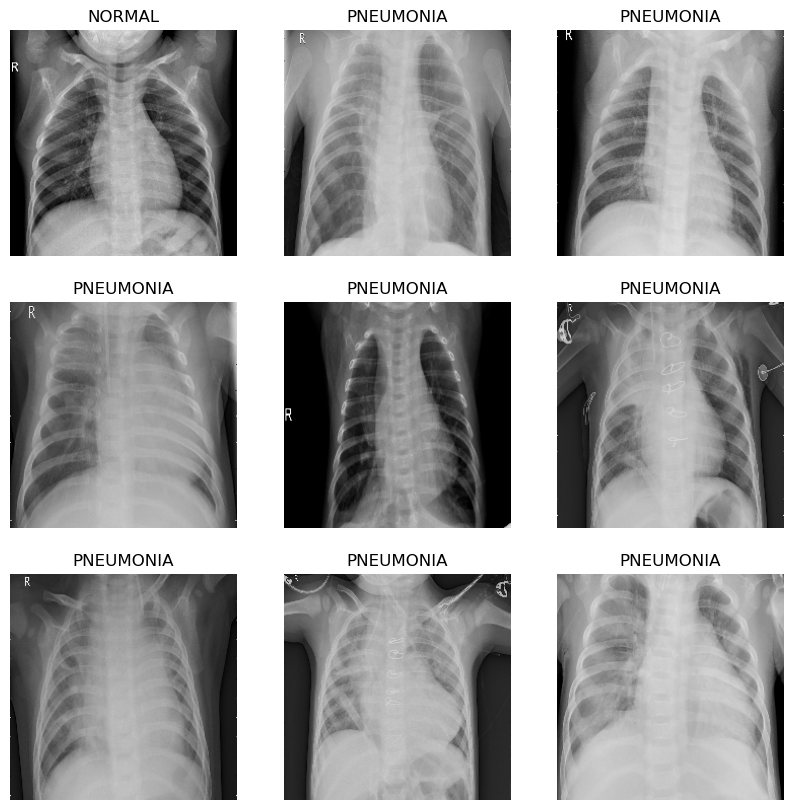

In [7]:
class_names = train_ds.class_names
print(f"Class names: {class_names}")

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [8]:
# Train the new layers on your dataset
epochs = 5
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Fine-tune the entire model or part of it by unfreezing some or all of the base model layers
base_model.trainable = True
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

fine_tune_epochs = 5
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

# Evaluate the fine-tuned model on the test set
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {accuracy}')

Epoch 1/5


2023-07-29 17:55:16.728911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-29 17:55:17.161798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/163 [..............................] - ETA: 19s - loss: 0.6217 - binary_accuracy: 0.7031  

2023-07-29 17:55:20.859409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:20.982617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/163 [..............................] - ETA: 16s - loss: 0.6073 - binary_accuracy: 0.6875

2023-07-29 17:55:21.080634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:21.181147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:21.269930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/163 [>.............................] - ETA: 15s - loss: 0.5742 - binary_accuracy: 0.7148

2023-07-29 17:55:21.368434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:21.466996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:21.564587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/163 [=>............................] - ETA: 15s - loss: 0.5294 - binary_accuracy: 0.7472

2023-07-29 17:55:21.674314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:21.772037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:21.866788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/163 [=>............................] - ETA: 14s - loss: 0.5211 - binary_accuracy: 0.7478

2023-07-29 17:55:21.961317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:22.059311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:22.154099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/163 [==>...........................] - ETA: 14s - loss: 0.5095 - binary_accuracy: 0.7518

2023-07-29 17:55:22.250280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:22.350106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:22.445403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/163 [==>...........................] - ETA: 14s - loss: 0.5053 - binary_accuracy: 0.7531

2023-07-29 17:55:22.545398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:22.645961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:22.743531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/163 [===>..........................] - ETA: 13s - loss: 0.4969 - binary_accuracy: 0.7527

2023-07-29 17:55:22.847850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:22.944124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:23.045552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/163 [===>..........................] - ETA: 13s - loss: 0.4847 - binary_accuracy: 0.7572

2023-07-29 17:55:23.150302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:23.244175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:23.339714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/163 [====>.........................] - ETA: 13s - loss: 0.4717 - binary_accuracy: 0.7672

2023-07-29 17:55:23.436547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:23.533836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:23.628854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/163 [====>.........................] - ETA: 12s - loss: 0.4640 - binary_accuracy: 0.7764

2023-07-29 17:55:23.723706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:23.822366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:23.918852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/163 [=====>........................] - ETA: 12s - loss: 0.4567 - binary_accuracy: 0.7830

2023-07-29 17:55:24.015792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:24.114996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:24.209366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/163 [=====>........................] - ETA: 12s - loss: 0.4482 - binary_accuracy: 0.7903

2023-07-29 17:55:24.307820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:24.401156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:24.498462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/163 [======>.......................] - ETA: 11s - loss: 0.4428 - binary_accuracy: 0.7927

2023-07-29 17:55:24.597395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:24.689371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:24.785994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/163 [=======>......................] - ETA: 11s - loss: 0.4363 - binary_accuracy: 0.7955

2023-07-29 17:55:24.884677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:24.981354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:25.076485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/163 [=======>......................] - ETA: 11s - loss: 0.4319 - binary_accuracy: 0.7959

2023-07-29 17:55:25.173969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:25.272623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:25.366662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/163 [========>.....................] - ETA: 11s - loss: 0.4288 - binary_accuracy: 0.7962

2023-07-29 17:55:25.459137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:25.550370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:25.646168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/163 [========>.....................] - ETA: 10s - loss: 0.4227 - binary_accuracy: 0.8001

2023-07-29 17:55:25.741715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:25.843177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:25.936905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/163 [=========>....................] - ETA: 10s - loss: 0.4191 - binary_accuracy: 0.8013

2023-07-29 17:55:26.035100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:26.124958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:26.226702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/163 [=========>....................] - ETA: 10s - loss: 0.4137 - binary_accuracy: 0.8046

2023-07-29 17:55:26.324582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:26.419697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:26.511879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/163 [==========>...................] - ETA: 9s - loss: 0.4101 - binary_accuracy: 0.8075

2023-07-29 17:55:26.606790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:26.701260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:26.797699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/163 [==========>...................] - ETA: 9s - loss: 0.4048 - binary_accuracy: 0.8101

2023-07-29 17:55:26.895760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:26.990458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:27.086681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/163 [===========>..................] - ETA: 9s - loss: 0.4010 - binary_accuracy: 0.8134

2023-07-29 17:55:27.183936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:27.277922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:27.373351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/163 [============>.................] - ETA: 8s - loss: 0.3975 - binary_accuracy: 0.8147

2023-07-29 17:55:27.474856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:27.567340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:27.663124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/163 [============>.................] - ETA: 8s - loss: 0.3928 - binary_accuracy: 0.8180

2023-07-29 17:55:27.762457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:27.864781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:27.958461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/163 [=============>................] - ETA: 8s - loss: 0.3870 - binary_accuracy: 0.8214

2023-07-29 17:55:28.051459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:28.150401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:28.248012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/163 [=============>................] - ETA: 8s - loss: 0.3852 - binary_accuracy: 0.8215

2023-07-29 17:55:28.347825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:28.450744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/163 [==============>...............] - ETA: 7s - loss: 0.3832 - binary_accuracy: 0.8232

2023-07-29 17:55:28.550835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:28.649978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:28.750975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/163 [==============>...............] - ETA: 7s - loss: 0.3806 - binary_accuracy: 0.8250

2023-07-29 17:55:28.846934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:28.944405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:29.043909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/163 [===============>..............] - ETA: 7s - loss: 0.3773 - binary_accuracy: 0.8278

2023-07-29 17:55:29.149923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:29.249007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:29.347650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/163 [===============>..............] - ETA: 7s - loss: 0.3734 - binary_accuracy: 0.8304

2023-07-29 17:55:29.454976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:29.556890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:29.649465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/163 [================>.............] - ETA: 6s - loss: 0.3704 - binary_accuracy: 0.8324

2023-07-29 17:55:29.747603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:29.839616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:29.933581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/163 [================>.............] - ETA: 6s - loss: 0.3692 - binary_accuracy: 0.8325

2023-07-29 17:55:30.033460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:30.134293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:30.235447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/163 [=================>............] - ETA: 6s - loss: 0.3670 - binary_accuracy: 0.8334

2023-07-29 17:55:30.334555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:30.428053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:30.522857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/163 [=================>............] - ETA: 5s - loss: 0.3631 - binary_accuracy: 0.8353

2023-07-29 17:55:30.617162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:30.715156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:30.807217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/163 [==================>...........] - ETA: 5s - loss: 0.3598 - binary_accuracy: 0.8370

2023-07-29 17:55:30.901027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:30.995837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:31.094232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/163 [===================>..........] - ETA: 5s - loss: 0.3554 - binary_accuracy: 0.8403

2023-07-29 17:55:31.196747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:31.298031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:31.387659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/163 [===================>..........] - ETA: 4s - loss: 0.3524 - binary_accuracy: 0.8415

2023-07-29 17:55:31.496066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:31.592648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:31.678913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/163 [====================>.........] - ETA: 4s - loss: 0.3491 - binary_accuracy: 0.8438

2023-07-29 17:55:31.776751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:31.873869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:31.965054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/163 [====================>.........] - ETA: 4s - loss: 0.3474 - binary_accuracy: 0.8432

2023-07-29 17:55:32.065756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:32.158385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:32.259996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/163 [=====================>........] - ETA: 4s - loss: 0.3434 - binary_accuracy: 0.8458

2023-07-29 17:55:32.356332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:32.448276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:32.543194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/163 [=====================>........] - ETA: 3s - loss: 0.3412 - binary_accuracy: 0.8465

2023-07-29 17:55:32.637358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:32.732428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:32.829477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/163 [======================>.......] - ETA: 3s - loss: 0.3377 - binary_accuracy: 0.8494

2023-07-29 17:55:32.923813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:33.016756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:33.112605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/163 [======================>.......] - ETA: 3s - loss: 0.3349 - binary_accuracy: 0.8510

2023-07-29 17:55:33.205397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:33.300662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:33.396870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/163 [=======================>......] - ETA: 2s - loss: 0.3316 - binary_accuracy: 0.8531

2023-07-29 17:55:33.490117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:33.582922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:33.679167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/163 [========================>.....] - ETA: 2s - loss: 0.3300 - binary_accuracy: 0.8545

2023-07-29 17:55:33.771531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:33.865579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:33.963337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/163 [========================>.....] - ETA: 2s - loss: 0.3271 - binary_accuracy: 0.8557

2023-07-29 17:55:34.064128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:34.157624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:34.257111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/163 [=========================>....] - ETA: 2s - loss: 0.3244 - binary_accuracy: 0.8570

2023-07-29 17:55:34.357944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:34.450346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:34.544998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/163 [=========================>....] - ETA: 1s - loss: 0.3211 - binary_accuracy: 0.8586

2023-07-29 17:55:34.642127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:34.736948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:34.831937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/163 [==========================>...] - ETA: 1s - loss: 0.3181 - binary_accuracy: 0.8598

2023-07-29 17:55:34.928177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:35.025395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:35.119341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/163 [==========================>...] - ETA: 1s - loss: 0.3171 - binary_accuracy: 0.8595

2023-07-29 17:55:35.211122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:35.305765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:35.406615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/163 [===========================>..] - ETA: 0s - loss: 0.3150 - binary_accuracy: 0.8608

2023-07-29 17:55:35.501427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:35.594418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:35.680629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/163 [===========================>..] - ETA: 0s - loss: 0.3133 - binary_accuracy: 0.8619

2023-07-29 17:55:35.765249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:35.850250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:35.935057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/163 [============================>.] - ETA: 0s - loss: 0.3114 - binary_accuracy: 0.8627

2023-07-29 17:55:36.021584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:36.109775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:36.200472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/163 [==============================] - ETA: 0s - loss: 0.3100 - binary_accuracy: 0.8635

2023-07-29 17:55:36.289516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:36.379933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:36.800226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 22s 103ms/step - loss: 0.3100 - binary_accuracy: 0.8635 - val_loss: 0.5201 - val_binary_accuracy: 0.6875
Epoch 2/5


2023-07-29 17:55:37.481494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/163 [..............................] - ETA: 15s - loss: 0.2275 - binary_accuracy: 0.8958

2023-07-29 17:55:37.864763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:37.960739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:38.053184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/163 [>.............................] - ETA: 14s - loss: 0.1754 - binary_accuracy: 0.9375

2023-07-29 17:55:38.147249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:38.244864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:38.345025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/163 [>.............................] - ETA: 14s - loss: 0.1807 - binary_accuracy: 0.9340

2023-07-29 17:55:38.442805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:38.533554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:38.637286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/163 [=>............................] - ETA: 14s - loss: 0.1881 - binary_accuracy: 0.9349

2023-07-29 17:55:38.735928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:38.835817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/163 [=>............................] - ETA: 14s - loss: 0.2046 - binary_accuracy: 0.9241

2023-07-29 17:55:38.936339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:39.038105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/163 [=>............................] - ETA: 14s - loss: 0.2044 - binary_accuracy: 0.9258

2023-07-29 17:55:39.140614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:39.238850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:39.332301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/163 [==>...........................] - ETA: 13s - loss: 0.2020 - binary_accuracy: 0.9243

2023-07-29 17:55:39.424839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:39.516570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:39.613149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/163 [===>..........................] - ETA: 13s - loss: 0.2040 - binary_accuracy: 0.9205

2023-07-29 17:55:39.702310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:39.798910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:39.888749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/163 [===>..........................] - ETA: 13s - loss: 0.2030 - binary_accuracy: 0.9212

2023-07-29 17:55:39.994241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:40.094995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/163 [===>..........................] - ETA: 13s - loss: 0.2042 - binary_accuracy: 0.9167

2023-07-29 17:55:40.200216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:40.294114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:40.395607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/163 [====>.........................] - ETA: 12s - loss: 0.2019 - binary_accuracy: 0.9187

2023-07-29 17:55:40.494301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:40.590573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:40.687231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/163 [=====>........................] - ETA: 12s - loss: 0.2011 - binary_accuracy: 0.9195

2023-07-29 17:55:40.790343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:40.885855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:40.983418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/163 [=====>........................] - ETA: 12s - loss: 0.2022 - binary_accuracy: 0.9210

2023-07-29 17:55:41.086947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:41.189452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:41.288620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/163 [======>.......................] - ETA: 12s - loss: 0.2100 - binary_accuracy: 0.9151

2023-07-29 17:55:41.389126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:41.491061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/163 [======>.......................] - ETA: 11s - loss: 0.2136 - binary_accuracy: 0.9131

2023-07-29 17:55:41.591200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:41.685903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:41.788657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/163 [=======>......................] - ETA: 11s - loss: 0.2122 - binary_accuracy: 0.9126

2023-07-29 17:55:41.882940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:41.986046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:42.078084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/163 [=======>......................] - ETA: 11s - loss: 0.2175 - binary_accuracy: 0.9102

2023-07-29 17:55:42.176300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:42.278549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/163 [========>.....................] - ETA: 11s - loss: 0.2155 - binary_accuracy: 0.9120

2023-07-29 17:55:42.381823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:42.482764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:42.576221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/163 [========>.....................] - ETA: 10s - loss: 0.2153 - binary_accuracy: 0.9123

2023-07-29 17:55:42.674039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:42.769469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:42.861442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/163 [=========>....................] - ETA: 10s - loss: 0.2150 - binary_accuracy: 0.9119

2023-07-29 17:55:42.954426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:43.050569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:43.150847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/163 [=========>....................] - ETA: 10s - loss: 0.2140 - binary_accuracy: 0.9122

2023-07-29 17:55:43.249421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:43.344027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:43.442332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/163 [==========>...................] - ETA: 9s - loss: 0.2136 - binary_accuracy: 0.9134 

2023-07-29 17:55:43.546013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:43.640430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:43.738787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/163 [==========>...................] - ETA: 9s - loss: 0.2115 - binary_accuracy: 0.9155

2023-07-29 17:55:43.830574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:43.927063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:44.016454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/163 [===========>..................] - ETA: 9s - loss: 0.2121 - binary_accuracy: 0.9160

2023-07-29 17:55:44.111447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:44.208008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:44.296083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/163 [===========>..................] - ETA: 9s - loss: 0.2101 - binary_accuracy: 0.9179

2023-07-29 17:55:44.399119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:44.493485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:44.588673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/163 [============>.................] - ETA: 8s - loss: 0.2097 - binary_accuracy: 0.9182

2023-07-29 17:55:44.683826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:44.775547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:44.867346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/163 [============>.................] - ETA: 8s - loss: 0.2098 - binary_accuracy: 0.9186

2023-07-29 17:55:44.961569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:45.053734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:45.142791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/163 [=============>................] - ETA: 8s - loss: 0.2109 - binary_accuracy: 0.9169

2023-07-29 17:55:45.243232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:45.336942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:45.432845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/163 [==============>...............] - ETA: 7s - loss: 0.2123 - binary_accuracy: 0.9154

2023-07-29 17:55:45.526287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:45.621299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:45.716431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/163 [==============>...............] - ETA: 7s - loss: 0.2114 - binary_accuracy: 0.9154

2023-07-29 17:55:45.805100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:45.900774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:45.994649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/163 [===============>..............] - ETA: 7s - loss: 0.2130 - binary_accuracy: 0.9141

2023-07-29 17:55:46.092057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:46.188753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:46.287983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/163 [===============>..............] - ETA: 6s - loss: 0.2124 - binary_accuracy: 0.9131

2023-07-29 17:55:46.379682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:46.475182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:46.569332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/163 [================>.............] - ETA: 6s - loss: 0.2115 - binary_accuracy: 0.9142

2023-07-29 17:55:46.669795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:46.764211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:46.855559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/163 [================>.............] - ETA: 6s - loss: 0.2103 - binary_accuracy: 0.9146

2023-07-29 17:55:46.953325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:47.051103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:47.143992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/163 [=================>............] - ETA: 6s - loss: 0.2097 - binary_accuracy: 0.9150

2023-07-29 17:55:47.238042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:47.333023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:47.437177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/163 [=================>............] - ETA: 5s - loss: 0.2086 - binary_accuracy: 0.9160

2023-07-29 17:55:47.533203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:47.629333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:47.721489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/163 [==================>...........] - ETA: 5s - loss: 0.2098 - binary_accuracy: 0.9151

2023-07-29 17:55:47.815193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:47.909467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:48.005051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/163 [===================>..........] - ETA: 5s - loss: 0.2094 - binary_accuracy: 0.9149

2023-07-29 17:55:48.099252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:48.197015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:48.289002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/163 [===================>..........] - ETA: 4s - loss: 0.2070 - binary_accuracy: 0.9163

2023-07-29 17:55:48.381068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:48.479704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:48.565954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/163 [====================>.........] - ETA: 4s - loss: 0.2062 - binary_accuracy: 0.9168

2023-07-29 17:55:48.659752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:48.755270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:48.848290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/163 [====================>.........] - ETA: 4s - loss: 0.2055 - binary_accuracy: 0.9168

2023-07-29 17:55:48.941303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:49.035051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:49.123731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/163 [=====================>........] - ETA: 4s - loss: 0.2061 - binary_accuracy: 0.9171

2023-07-29 17:55:49.217523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:49.319545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:49.412936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/163 [=====================>........] - ETA: 3s - loss: 0.2062 - binary_accuracy: 0.9158

2023-07-29 17:55:49.506335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:49.601880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:49.697076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/163 [======================>.......] - ETA: 3s - loss: 0.2055 - binary_accuracy: 0.9156

2023-07-29 17:55:49.792717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:49.887318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:49.979514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/163 [======================>.......] - ETA: 3s - loss: 0.2042 - binary_accuracy: 0.9163

2023-07-29 17:55:50.075531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:50.167893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:50.260559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/163 [=======================>......] - ETA: 2s - loss: 0.2034 - binary_accuracy: 0.9173

2023-07-29 17:55:50.354478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:50.445138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:50.541737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/163 [========================>.....] - ETA: 2s - loss: 0.2017 - binary_accuracy: 0.9180

2023-07-29 17:55:50.636492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:50.730905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:50.826669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/163 [========================>.....] - ETA: 2s - loss: 0.2002 - binary_accuracy: 0.9186

2023-07-29 17:55:50.918535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:51.011169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:51.109893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/163 [=========================>....] - ETA: 2s - loss: 0.1997 - binary_accuracy: 0.9188

2023-07-29 17:55:51.213888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:51.310686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:51.410681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/163 [=========================>....] - ETA: 1s - loss: 0.1995 - binary_accuracy: 0.9183

2023-07-29 17:55:51.508446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:51.605422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:51.695199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/163 [==========================>...] - ETA: 1s - loss: 0.1994 - binary_accuracy: 0.9185

2023-07-29 17:55:51.794424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:51.892699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:51.983708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/163 [==========================>...] - ETA: 1s - loss: 0.1980 - binary_accuracy: 0.9193

2023-07-29 17:55:52.082791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:52.178704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:52.276488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/163 [===========================>..] - ETA: 0s - loss: 0.1980 - binary_accuracy: 0.9192

2023-07-29 17:55:52.373569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:52.464021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:52.551134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/163 [===========================>..] - ETA: 0s - loss: 0.1981 - binary_accuracy: 0.9194

2023-07-29 17:55:52.637440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:52.721063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:52.807990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/163 [============================>.] - ETA: 0s - loss: 0.1984 - binary_accuracy: 0.9193

2023-07-29 17:55:52.894082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:52.980591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:53.068361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/163 [==============================] - ETA: 0s - loss: 0.1975 - binary_accuracy: 0.9197

2023-07-29 17:55:53.153483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:53.239044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/163 [==============================] - 16s 96ms/step - loss: 0.1975 - binary_accuracy: 0.9197 - val_loss: 0.4833 - val_binary_accuracy: 0.8125
Epoch 3/5


2023-07-29 17:55:53.399778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/163 [..............................] - ETA: 15s - loss: 0.1451 - binary_accuracy: 0.9583

2023-07-29 17:55:53.779756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:53.875631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:53.967192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/163 [>.............................] - ETA: 14s - loss: 0.1378 - binary_accuracy: 0.9688

2023-07-29 17:55:54.059560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:54.155661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:54.247217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/163 [>.............................] - ETA: 14s - loss: 0.1513 - binary_accuracy: 0.9514

2023-07-29 17:55:54.337600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:54.430198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:54.530126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/163 [=>............................] - ETA: 14s - loss: 0.1515 - binary_accuracy: 0.9505

2023-07-29 17:55:54.626829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:54.723109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:54.825840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/163 [=>............................] - ETA: 14s - loss: 0.1553 - binary_accuracy: 0.9500

2023-07-29 17:55:54.921235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:55.020611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/163 [==>...........................] - ETA: 13s - loss: 0.1591 - binary_accuracy: 0.9467

2023-07-29 17:55:55.125734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:55.217946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:55.312768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/163 [==>...........................] - ETA: 13s - loss: 0.1594 - binary_accuracy: 0.9453

2023-07-29 17:55:55.404650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:55.496142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:55.588701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/163 [===>..........................] - ETA: 13s - loss: 0.1624 - binary_accuracy: 0.9402

2023-07-29 17:55:55.678316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:55.773854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:55.868205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/163 [===>..........................] - ETA: 13s - loss: 0.1647 - binary_accuracy: 0.9411

2023-07-29 17:55:55.960496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:56.061410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:56.153076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/163 [====>.........................] - ETA: 12s - loss: 0.1649 - binary_accuracy: 0.9418

2023-07-29 17:55:56.246201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:56.339107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:56.430749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/163 [====>.........................] - ETA: 12s - loss: 0.1639 - binary_accuracy: 0.9434

2023-07-29 17:55:56.526824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:56.620446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:56.721279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/163 [=====>........................] - ETA: 12s - loss: 0.1711 - binary_accuracy: 0.9393

2023-07-29 17:55:56.816827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:56.915018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:57.009375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/163 [=====>........................] - ETA: 11s - loss: 0.1695 - binary_accuracy: 0.9367

2023-07-29 17:55:57.107795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:57.204334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:57.298826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/163 [======>.......................] - ETA: 11s - loss: 0.1691 - binary_accuracy: 0.9360

2023-07-29 17:55:57.394597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:57.485996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:57.580372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/163 [=======>......................] - ETA: 11s - loss: 0.1734 - binary_accuracy: 0.9325

2023-07-29 17:55:57.677519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:57.782378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/163 [=======>......................] - ETA: 11s - loss: 0.1725 - binary_accuracy: 0.9334

2023-07-29 17:55:57.878953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:57.981378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/163 [=======>......................] - ETA: 11s - loss: 0.1701 - binary_accuracy: 0.9349

2023-07-29 17:55:58.085676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:58.186850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/163 [========>.....................] - ETA: 10s - loss: 0.1705 - binary_accuracy: 0.9344

2023-07-29 17:55:58.287112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:58.378429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:58.470412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/163 [========>.....................] - ETA: 10s - loss: 0.1714 - binary_accuracy: 0.9340

2023-07-29 17:55:58.565470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:58.658847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:58.753248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/163 [=========>....................] - ETA: 10s - loss: 0.1739 - binary_accuracy: 0.9319

2023-07-29 17:55:58.852453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:58.944346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:59.040396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/163 [=========>....................] - ETA: 9s - loss: 0.1785 - binary_accuracy: 0.9296 

2023-07-29 17:55:59.137290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:59.242606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:59.341354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/163 [==========>...................] - ETA: 9s - loss: 0.1831 - binary_accuracy: 0.9279

2023-07-29 17:55:59.445615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:59.552346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/163 [==========>...................] - ETA: 9s - loss: 0.1830 - binary_accuracy: 0.9272

2023-07-29 17:55:59.651891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:59.749587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:55:59.843367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/163 [===========>..................] - ETA: 9s - loss: 0.1812 - binary_accuracy: 0.9272

2023-07-29 17:55:59.946245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:00.047894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:00.141642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/163 [===========>..................] - ETA: 8s - loss: 0.1797 - binary_accuracy: 0.9281

2023-07-29 17:56:00.240881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:00.343290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:00.442883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/163 [============>.................] - ETA: 8s - loss: 0.1802 - binary_accuracy: 0.9285

2023-07-29 17:56:00.542690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:00.631500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:00.730407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/163 [============>.................] - ETA: 8s - loss: 0.1809 - binary_accuracy: 0.9280

2023-07-29 17:56:00.821759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:00.914664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:01.009451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/163 [=============>................] - ETA: 8s - loss: 0.1787 - binary_accuracy: 0.9300

2023-07-29 17:56:01.107292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:01.199697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:01.293164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/163 [==============>...............] - ETA: 7s - loss: 0.1778 - binary_accuracy: 0.9310

2023-07-29 17:56:01.386380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:01.477767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:01.578387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/163 [==============>...............] - ETA: 7s - loss: 0.1774 - binary_accuracy: 0.9309

2023-07-29 17:56:01.674077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:01.767902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:01.867311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/163 [===============>..............] - ETA: 7s - loss: 0.1778 - binary_accuracy: 0.9311

2023-07-29 17:56:01.962386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:02.056419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:02.146979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/163 [===============>..............] - ETA: 6s - loss: 0.1791 - binary_accuracy: 0.9303

2023-07-29 17:56:02.241670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:02.334788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:02.432136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/163 [================>.............] - ETA: 6s - loss: 0.1795 - binary_accuracy: 0.9305

2023-07-29 17:56:02.532360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:02.632215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:02.725645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/163 [================>.............] - ETA: 6s - loss: 0.1793 - binary_accuracy: 0.9304

2023-07-29 17:56:02.826434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:02.922242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:03.011630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/163 [=================>............] - ETA: 6s - loss: 0.1783 - binary_accuracy: 0.9306

2023-07-29 17:56:03.105028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:03.200021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:03.298424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/163 [=================>............] - ETA: 5s - loss: 0.1781 - binary_accuracy: 0.9308

2023-07-29 17:56:03.401151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:03.492281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:03.586871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/163 [==================>...........] - ETA: 5s - loss: 0.1787 - binary_accuracy: 0.9310

2023-07-29 17:56:03.681048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:03.773125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:03.865101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/163 [===================>..........] - ETA: 5s - loss: 0.1781 - binary_accuracy: 0.9303

2023-07-29 17:56:03.959470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:04.057004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:04.148207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/163 [===================>..........] - ETA: 4s - loss: 0.1773 - binary_accuracy: 0.9308

2023-07-29 17:56:04.243209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:04.335420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:04.426714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/163 [====================>.........] - ETA: 4s - loss: 0.1774 - binary_accuracy: 0.9307

2023-07-29 17:56:04.519534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:04.620016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:04.716066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/163 [====================>.........] - ETA: 4s - loss: 0.1765 - binary_accuracy: 0.9314

2023-07-29 17:56:04.817739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:04.914252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:05.016102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/163 [=====================>........] - ETA: 4s - loss: 0.1750 - binary_accuracy: 0.9318

2023-07-29 17:56:05.111468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:05.211566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:05.312760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/163 [=====================>........] - ETA: 3s - loss: 0.1739 - binary_accuracy: 0.9320

2023-07-29 17:56:05.407046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:05.501287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:05.596213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/163 [======================>.......] - ETA: 3s - loss: 0.1734 - binary_accuracy: 0.9321

2023-07-29 17:56:05.694564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:05.786694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:05.888763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/163 [======================>.......] - ETA: 3s - loss: 0.1724 - binary_accuracy: 0.9322

2023-07-29 17:56:05.986981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:06.079822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:06.182089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/163 [=======================>......] - ETA: 2s - loss: 0.1712 - binary_accuracy: 0.9330

2023-07-29 17:56:06.278461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:06.373757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:06.468720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/163 [========================>.....] - ETA: 2s - loss: 0.1714 - binary_accuracy: 0.9331

2023-07-29 17:56:06.562213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:06.657530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:06.753987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/163 [========================>.....] - ETA: 2s - loss: 0.1698 - binary_accuracy: 0.9339

2023-07-29 17:56:06.856323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:06.953861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:07.050627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/163 [=========================>....] - ETA: 2s - loss: 0.1684 - binary_accuracy: 0.9346

2023-07-29 17:56:07.152847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:07.251298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:07.341882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/163 [=========================>....] - ETA: 1s - loss: 0.1682 - binary_accuracy: 0.9347

2023-07-29 17:56:07.440176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:07.539742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:07.634113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/163 [==========================>...] - ETA: 1s - loss: 0.1677 - binary_accuracy: 0.9350

2023-07-29 17:56:07.731158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:07.822071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:07.919885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/163 [==========================>...] - ETA: 1s - loss: 0.1668 - binary_accuracy: 0.9352

2023-07-29 17:56:08.017589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:08.115841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:08.212678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/163 [===========================>..] - ETA: 0s - loss: 0.1669 - binary_accuracy: 0.9351

2023-07-29 17:56:08.315538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:08.403146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:08.493315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/163 [===========================>..] - ETA: 0s - loss: 0.1683 - binary_accuracy: 0.9339

2023-07-29 17:56:08.582144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:08.671003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:08.758129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/163 [============================>.] - ETA: 0s - loss: 0.1682 - binary_accuracy: 0.9338

2023-07-29 17:56:08.845927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:08.935206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:09.022052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/163 [==============================] - ETA: 0s - loss: 0.1670 - binary_accuracy: 0.9348

2023-07-29 17:56:09.109364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:09.196764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/163 [==============================] - 16s 96ms/step - loss: 0.1670 - binary_accuracy: 0.9348 - val_loss: 0.3986 - val_binary_accuracy: 0.8125
Epoch 4/5


2023-07-29 17:56:09.360327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/163 [..............................] - ETA: 15s - loss: 0.1475 - binary_accuracy: 0.9479

2023-07-29 17:56:09.734305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:09.829541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:09.924543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/163 [>.............................] - ETA: 15s - loss: 0.1293 - binary_accuracy: 0.9531

2023-07-29 17:56:10.023084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:10.120553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:10.218868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/163 [>.............................] - ETA: 14s - loss: 0.1348 - binary_accuracy: 0.9549

2023-07-29 17:56:10.316479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:10.413388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:10.514072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/163 [=>............................] - ETA: 14s - loss: 0.1357 - binary_accuracy: 0.9531

2023-07-29 17:56:10.617629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:10.716905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:10.813295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/163 [=>............................] - ETA: 14s - loss: 0.1348 - binary_accuracy: 0.9563

2023-07-29 17:56:10.915595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:11.017585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:11.116672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/163 [==>...........................] - ETA: 14s - loss: 0.1456 - binary_accuracy: 0.9514

2023-07-29 17:56:11.209969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:11.304468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:11.396285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/163 [==>...........................] - ETA: 13s - loss: 0.1512 - binary_accuracy: 0.9494

2023-07-29 17:56:11.494159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:11.593038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:11.693155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/163 [===>..........................] - ETA: 13s - loss: 0.1618 - binary_accuracy: 0.9479

2023-07-29 17:56:11.789212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:11.886782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:11.989578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/163 [===>..........................] - ETA: 13s - loss: 0.1544 - binary_accuracy: 0.9502

2023-07-29 17:56:12.093316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:12.186359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:12.281662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/163 [====>.........................] - ETA: 13s - loss: 0.1521 - binary_accuracy: 0.9510

2023-07-29 17:56:12.380060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:12.472723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:12.570265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/163 [=====>........................] - ETA: 12s - loss: 0.1527 - binary_accuracy: 0.9498

2023-07-29 17:56:12.674185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:12.775757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:12.869593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/163 [=====>........................] - ETA: 12s - loss: 0.1563 - binary_accuracy: 0.9479

2023-07-29 17:56:12.967990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:13.060736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:13.160544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/163 [======>.......................] - ETA: 12s - loss: 0.1602 - binary_accuracy: 0.9455

2023-07-29 17:56:13.260693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:13.360104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:13.457559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/163 [======>.......................] - ETA: 11s - loss: 0.1634 - binary_accuracy: 0.9435

2023-07-29 17:56:13.554773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:13.652462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:13.748320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/163 [=======>......................] - ETA: 11s - loss: 0.1648 - binary_accuracy: 0.9424

2023-07-29 17:56:13.844241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:13.944072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:14.044086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/163 [=======>......................] - ETA: 11s - loss: 0.1672 - binary_accuracy: 0.9408

2023-07-29 17:56:14.139175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:14.239458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:14.332729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/163 [========>.....................] - ETA: 10s - loss: 0.1676 - binary_accuracy: 0.9406

2023-07-29 17:56:14.425711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:14.517862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:14.613770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/163 [========>.....................] - ETA: 10s - loss: 0.1679 - binary_accuracy: 0.9387

2023-07-29 17:56:14.705303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:14.802080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:14.901348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/163 [=========>....................] - ETA: 10s - loss: 0.1655 - binary_accuracy: 0.9408

2023-07-29 17:56:14.995282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:15.095124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:15.193357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/163 [==========>...................] - ETA: 10s - loss: 0.1629 - binary_accuracy: 0.9417

2023-07-29 17:56:15.292313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:15.390254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:15.483488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/163 [==========>...................] - ETA: 9s - loss: 0.1636 - binary_accuracy: 0.9410

2023-07-29 17:56:15.579366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:15.675160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:15.766596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/163 [===========>..................] - ETA: 9s - loss: 0.1617 - binary_accuracy: 0.9418

2023-07-29 17:56:15.859547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:15.958020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:16.056699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/163 [===========>..................] - ETA: 9s - loss: 0.1608 - binary_accuracy: 0.9425

2023-07-29 17:56:16.150622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:16.242713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:16.340289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/163 [============>.................] - ETA: 8s - loss: 0.1607 - binary_accuracy: 0.9423

2023-07-29 17:56:16.437256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:16.532916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:16.628496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/163 [============>.................] - ETA: 8s - loss: 0.1618 - binary_accuracy: 0.9417

2023-07-29 17:56:16.724944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:16.820159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:16.917474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/163 [=============>................] - ETA: 8s - loss: 0.1619 - binary_accuracy: 0.9419

2023-07-29 17:56:17.017038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:17.114036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:17.209870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/163 [=============>................] - ETA: 7s - loss: 0.1642 - binary_accuracy: 0.9406

2023-07-29 17:56:17.304030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:17.396062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:17.484556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/163 [==============>...............] - ETA: 7s - loss: 0.1654 - binary_accuracy: 0.9397

2023-07-29 17:56:17.576908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:17.672050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:17.759947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/163 [===============>..............] - ETA: 7s - loss: 0.1644 - binary_accuracy: 0.9404

2023-07-29 17:56:17.859738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:17.950617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:18.051294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/163 [===============>..............] - ETA: 7s - loss: 0.1632 - binary_accuracy: 0.9406

2023-07-29 17:56:18.144817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:18.238988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:18.332467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/163 [================>.............] - ETA: 6s - loss: 0.1636 - binary_accuracy: 0.9395

2023-07-29 17:56:18.433351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:18.525662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:18.620134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/163 [================>.............] - ETA: 6s - loss: 0.1631 - binary_accuracy: 0.9395

2023-07-29 17:56:18.714314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:18.811197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:18.910764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/163 [=================>............] - ETA: 6s - loss: 0.1627 - binary_accuracy: 0.9403

2023-07-29 17:56:19.003614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:19.100272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:19.196631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/163 [=================>............] - ETA: 5s - loss: 0.1631 - binary_accuracy: 0.9406

2023-07-29 17:56:19.291035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:19.391527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:19.487241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/163 [==================>...........] - ETA: 5s - loss: 0.1621 - binary_accuracy: 0.9411

2023-07-29 17:56:19.581271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:19.674338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:19.768742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/163 [==================>...........] - ETA: 5s - loss: 0.1612 - binary_accuracy: 0.9416

2023-07-29 17:56:19.864014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:19.960481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:20.049282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/163 [===================>..........] - ETA: 5s - loss: 0.1618 - binary_accuracy: 0.9406

2023-07-29 17:56:20.145575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:20.243071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:20.337076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/163 [===================>..........] - ETA: 4s - loss: 0.1619 - binary_accuracy: 0.9402

2023-07-29 17:56:20.427114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:20.520225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:20.619467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/163 [====================>.........] - ETA: 4s - loss: 0.1618 - binary_accuracy: 0.9396

2023-07-29 17:56:20.714750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:20.809476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:20.897034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/163 [=====================>........] - ETA: 4s - loss: 0.1610 - binary_accuracy: 0.9406

2023-07-29 17:56:21.008384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:21.106488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:21.206747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/163 [=====================>........] - ETA: 3s - loss: 0.1615 - binary_accuracy: 0.9403

2023-07-29 17:56:21.299718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:21.397837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:21.492058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/163 [======================>.......] - ETA: 3s - loss: 0.1612 - binary_accuracy: 0.9402

2023-07-29 17:56:21.587701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:21.690132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:21.787752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/163 [======================>.......] - ETA: 3s - loss: 0.1593 - binary_accuracy: 0.9414

2023-07-29 17:56:21.878304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:21.978356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:22.077057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/163 [=======================>......] - ETA: 2s - loss: 0.1586 - binary_accuracy: 0.9418

2023-07-29 17:56:22.173921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:22.268457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:22.360526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/163 [=======================>......] - ETA: 2s - loss: 0.1584 - binary_accuracy: 0.9424

2023-07-29 17:56:22.456959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:22.553719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:22.646441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/163 [========================>.....] - ETA: 2s - loss: 0.1568 - binary_accuracy: 0.9432

2023-07-29 17:56:22.743021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:22.834484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:22.931117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/163 [========================>.....] - ETA: 2s - loss: 0.1563 - binary_accuracy: 0.9433

2023-07-29 17:56:23.026095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:23.119247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:23.211455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/163 [=========================>....] - ETA: 1s - loss: 0.1555 - binary_accuracy: 0.9434

2023-07-29 17:56:23.309260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:23.404218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:23.499044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/163 [==========================>...] - ETA: 1s - loss: 0.1556 - binary_accuracy: 0.9435

2023-07-29 17:56:23.589349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:23.682998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:23.780258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/163 [==========================>...] - ETA: 1s - loss: 0.1542 - binary_accuracy: 0.9444

2023-07-29 17:56:23.875359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:23.974250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:24.068246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/163 [===========================>..] - ETA: 0s - loss: 0.1536 - binary_accuracy: 0.9446

2023-07-29 17:56:24.165761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:24.258226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:24.344968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/163 [===========================>..] - ETA: 0s - loss: 0.1539 - binary_accuracy: 0.9447

2023-07-29 17:56:24.429620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:24.519360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:24.602990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/163 [============================>.] - ETA: 0s - loss: 0.1532 - binary_accuracy: 0.9448

2023-07-29 17:56:24.687790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:24.770066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:24.853837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/163 [============================>.] - ETA: 0s - loss: 0.1527 - binary_accuracy: 0.9450

2023-07-29 17:56:24.939310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:25.023051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:25.108015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/163 [==============================] - 16s 96ms/step - loss: 0.1534 - binary_accuracy: 0.9446 - val_loss: 0.4244 - val_binary_accuracy: 0.8125
Epoch 5/5


2023-07-29 17:56:25.273255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/163 [..............................] - ETA: 14s - loss: 0.1027 - binary_accuracy: 0.9688

2023-07-29 17:56:25.646598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:25.745449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:25.836942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/163 [>.............................] - ETA: 14s - loss: 0.1208 - binary_accuracy: 0.9635

2023-07-29 17:56:25.930997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:26.023592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:26.114289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/163 [>.............................] - ETA: 14s - loss: 0.1223 - binary_accuracy: 0.9549

2023-07-29 17:56:26.206582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:26.300136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:26.395521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/163 [=>............................] - ETA: 14s - loss: 0.1341 - binary_accuracy: 0.9531

2023-07-29 17:56:26.488155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:26.582897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:26.675983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/163 [=>............................] - ETA: 13s - loss: 0.1357 - binary_accuracy: 0.9479

2023-07-29 17:56:26.774083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:26.871387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:26.973200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/163 [==>...........................] - ETA: 13s - loss: 0.1263 - binary_accuracy: 0.9531

2023-07-29 17:56:27.072549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:27.169767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:27.264831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/163 [==>...........................] - ETA: 13s - loss: 0.1226 - binary_accuracy: 0.9539

2023-07-29 17:56:27.357159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:27.449178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:27.541283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/163 [===>..........................] - ETA: 13s - loss: 0.1231 - binary_accuracy: 0.9544

2023-07-29 17:56:27.633675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:27.727485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:27.826074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/163 [===>..........................] - ETA: 12s - loss: 0.1268 - binary_accuracy: 0.9514

2023-07-29 17:56:27.922962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:28.016926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:28.111686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/163 [====>.........................] - ETA: 12s - loss: 0.1262 - binary_accuracy: 0.9531

2023-07-29 17:56:28.204372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:28.294378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:28.392172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/163 [=====>........................] - ETA: 12s - loss: 0.1290 - binary_accuracy: 0.9517

2023-07-29 17:56:28.485793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:28.581057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:28.673875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/163 [=====>........................] - ETA: 11s - loss: 0.1349 - binary_accuracy: 0.9488

2023-07-29 17:56:28.766351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:28.860216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:28.953784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/163 [======>.......................] - ETA: 11s - loss: 0.1343 - binary_accuracy: 0.9495

2023-07-29 17:56:29.047348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:29.139147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:29.232541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/163 [======>.......................] - ETA: 11s - loss: 0.1390 - binary_accuracy: 0.9472

2023-07-29 17:56:29.328099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:29.420215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:29.513382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/163 [=======>......................] - ETA: 11s - loss: 0.1396 - binary_accuracy: 0.9479

2023-07-29 17:56:29.609454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:29.696693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:29.788904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/163 [=======>......................] - ETA: 10s - loss: 0.1384 - binary_accuracy: 0.9479

2023-07-29 17:56:29.885650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:29.976183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:30.069974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/163 [========>.....................] - ETA: 10s - loss: 0.1407 - binary_accuracy: 0.9473

2023-07-29 17:56:30.159460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:30.252462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:30.343927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/163 [========>.....................] - ETA: 10s - loss: 0.1406 - binary_accuracy: 0.9468

2023-07-29 17:56:30.442902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:30.535179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:30.631681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/163 [=========>....................] - ETA: 9s - loss: 0.1420 - binary_accuracy: 0.9463 

2023-07-29 17:56:30.723786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:30.818293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:30.911295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/163 [==========>...................] - ETA: 9s - loss: 0.1430 - binary_accuracy: 0.9453

2023-07-29 17:56:31.014456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:31.109149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:31.200189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/163 [==========>...................] - ETA: 9s - loss: 0.1421 - binary_accuracy: 0.9459

2023-07-29 17:56:31.294629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:31.387214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:31.479688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/163 [===========>..................] - ETA: 9s - loss: 0.1396 - binary_accuracy: 0.9479

2023-07-29 17:56:31.571621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:31.659164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:31.754607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/163 [===========>..................] - ETA: 8s - loss: 0.1415 - binary_accuracy: 0.9484

2023-07-29 17:56:31.847564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:31.940831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:32.036747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/163 [============>.................] - ETA: 8s - loss: 0.1407 - binary_accuracy: 0.9484

2023-07-29 17:56:32.126366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:32.224357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:32.313749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/163 [============>.................] - ETA: 8s - loss: 0.1397 - binary_accuracy: 0.9488

2023-07-29 17:56:32.405886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:32.503357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:32.596919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/163 [=============>................] - ETA: 7s - loss: 0.1400 - binary_accuracy: 0.9479

2023-07-29 17:56:32.691963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:32.785268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:32.877556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/163 [=============>................] - ETA: 7s - loss: 0.1430 - binary_accuracy: 0.9475

2023-07-29 17:56:32.966993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:33.055599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:33.145594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/163 [==============>...............] - ETA: 7s - loss: 0.1458 - binary_accuracy: 0.9457

2023-07-29 17:56:33.242255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:33.332275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:33.426282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/163 [===============>..............] - ETA: 7s - loss: 0.1452 - binary_accuracy: 0.9465

2023-07-29 17:56:33.524891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:33.615010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:33.706222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/163 [===============>..............] - ETA: 6s - loss: 0.1448 - binary_accuracy: 0.9462

2023-07-29 17:56:33.798614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:33.887934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:33.985219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/163 [================>.............] - ETA: 6s - loss: 0.1447 - binary_accuracy: 0.9459

2023-07-29 17:56:34.078995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:34.171701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:34.261797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/163 [================>.............] - ETA: 6s - loss: 0.1437 - binary_accuracy: 0.9463

2023-07-29 17:56:34.351574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:34.445359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:34.543249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/163 [=================>............] - ETA: 5s - loss: 0.1437 - binary_accuracy: 0.9460

2023-07-29 17:56:34.633968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:34.725018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:34.815978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/163 [=================>............] - ETA: 5s - loss: 0.1429 - binary_accuracy: 0.9470

2023-07-29 17:56:34.914372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:35.009194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:35.103932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/163 [==================>...........] - ETA: 5s - loss: 0.1430 - binary_accuracy: 0.9461

2023-07-29 17:56:35.193254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:35.288064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:35.379600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/163 [==================>...........] - ETA: 5s - loss: 0.1435 - binary_accuracy: 0.9450

2023-07-29 17:56:35.470224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:35.564604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:35.657469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/163 [===================>..........] - ETA: 4s - loss: 0.1427 - binary_accuracy: 0.9457

2023-07-29 17:56:35.752285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:35.852728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:35.946835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/163 [===================>..........] - ETA: 4s - loss: 0.1417 - binary_accuracy: 0.9465

2023-07-29 17:56:36.036599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:36.127660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:36.225098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/163 [====================>.........] - ETA: 4s - loss: 0.1415 - binary_accuracy: 0.9466

2023-07-29 17:56:36.315050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:36.411473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:36.504051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/163 [=====================>........] - ETA: 4s - loss: 0.1424 - binary_accuracy: 0.9456

2023-07-29 17:56:36.601736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:36.697554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:36.794398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/163 [=====================>........] - ETA: 3s - loss: 0.1432 - binary_accuracy: 0.9454

2023-07-29 17:56:36.885023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:36.979385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:37.072876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/163 [======================>.......] - ETA: 3s - loss: 0.1423 - binary_accuracy: 0.9454

2023-07-29 17:56:37.162763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:37.258008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:37.353228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/163 [======================>.......] - ETA: 3s - loss: 0.1412 - binary_accuracy: 0.9455

2023-07-29 17:56:37.448205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:37.540084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:37.634271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/163 [=======================>......] - ETA: 2s - loss: 0.1400 - binary_accuracy: 0.9463

2023-07-29 17:56:37.731311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:37.819762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:37.914786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/163 [=======================>......] - ETA: 2s - loss: 0.1387 - binary_accuracy: 0.9468

2023-07-29 17:56:38.011520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:38.103234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:38.195947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/163 [========================>.....] - ETA: 2s - loss: 0.1392 - binary_accuracy: 0.9461

2023-07-29 17:56:38.290325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:38.382534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:38.474542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/163 [========================>.....] - ETA: 2s - loss: 0.1387 - binary_accuracy: 0.9459

2023-07-29 17:56:38.573753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:38.667079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:38.760936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/163 [=========================>....] - ETA: 1s - loss: 0.1381 - binary_accuracy: 0.9460

2023-07-29 17:56:38.856930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:38.951439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:39.047064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/163 [==========================>...] - ETA: 1s - loss: 0.1373 - binary_accuracy: 0.9464

2023-07-29 17:56:39.136156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:39.229754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:39.320595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/163 [==========================>...] - ETA: 1s - loss: 0.1375 - binary_accuracy: 0.9465

2023-07-29 17:56:39.416670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:39.507256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:39.598637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/163 [===========================>..] - ETA: 0s - loss: 0.1365 - binary_accuracy: 0.9467

2023-07-29 17:56:39.695622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:39.788517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:39.878306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/163 [===========================>..] - ETA: 0s - loss: 0.1363 - binary_accuracy: 0.9469

2023-07-29 17:56:39.962480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:40.047124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:40.130538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/163 [============================>.] - ETA: 0s - loss: 0.1366 - binary_accuracy: 0.9467

2023-07-29 17:56:40.216134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:40.300265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:40.383945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/163 [============================>.] - ETA: 0s - loss: 0.1375 - binary_accuracy: 0.9466

2023-07-29 17:56:40.472443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:40.558414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-29 17:56:40.642164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/163 [==============================] - 16s 94ms/step - loss: 0.1373 - binary_accuracy: 0.9465 - val_loss: 0.3980 - val_binary_accuracy: 0.8125


Epoch 5/10


2023-07-29 17:56:43.114920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-29 17:56:43.897350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/163 [..............................] - ETA: 28:46 - loss: 0.1025 - binary_accuracy: 0.9688

2023-07-29 17:56:51.522852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/163 [..............................] - ETA: 2:13 - loss: 0.0698 - binary_accuracy: 0.9844 

2023-07-29 17:56:52.316406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/163 [..............................] - ETA: 1:33 - loss: 0.0762 - binary_accuracy: 0.9792

2023-07-29 17:56:52.649109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/163 [..............................] - ETA: 1:31 - loss: 0.0866 - binary_accuracy: 0.9688

2023-07-29 17:56:53.209301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/163 [..............................] - ETA: 1:19 - loss: 0.0945 - binary_accuracy: 0.9688

2023-07-29 17:56:53.508213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/163 [>.............................] - ETA: 1:14 - loss: 0.1162 - binary_accuracy: 0.9583

2023-07-29 17:56:53.838895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/163 [>.............................] - ETA: 1:08 - loss: 0.1185 - binary_accuracy: 0.9554

2023-07-29 17:56:54.135637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/163 [>.............................] - ETA: 1:05 - loss: 0.1239 - binary_accuracy: 0.9570

2023-07-29 17:56:54.423297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/163 [>.............................] - ETA: 1:02 - loss: 0.1496 - binary_accuracy: 0.9514

2023-07-29 17:56:54.725691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/163 [>.............................] - ETA: 59s - loss: 0.1407 - binary_accuracy: 0.9563 

2023-07-29 17:56:55.002029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/163 [=>............................] - ETA: 58s - loss: 0.1366 - binary_accuracy: 0.9545

2023-07-29 17:56:55.312457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/163 [=>............................] - ETA: 56s - loss: 0.1323 - binary_accuracy: 0.9557

2023-07-29 17:56:55.602329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/163 [=>............................] - ETA: 55s - loss: 0.1369 - binary_accuracy: 0.9519

2023-07-29 17:56:55.889362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/163 [=>............................] - ETA: 53s - loss: 0.1324 - binary_accuracy: 0.9531

2023-07-29 17:56:56.184583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/163 [=>............................] - ETA: 52s - loss: 0.1304 - binary_accuracy: 0.9542

2023-07-29 17:56:56.481914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/163 [=>............................] - ETA: 51s - loss: 0.1369 - binary_accuracy: 0.9492

2023-07-29 17:56:56.769855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/163 [==>...........................] - ETA: 51s - loss: 0.1321 - binary_accuracy: 0.9522

2023-07-29 17:56:57.074392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/163 [==>...........................] - ETA: 50s - loss: 0.1331 - binary_accuracy: 0.9497

2023-07-29 17:56:57.374149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/163 [==>...........................] - ETA: 49s - loss: 0.1333 - binary_accuracy: 0.9507

2023-07-29 17:56:57.649693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/163 [==>...........................] - ETA: 48s - loss: 0.1339 - binary_accuracy: 0.9500

2023-07-29 17:56:57.934633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/163 [==>...........................] - ETA: 47s - loss: 0.1399 - binary_accuracy: 0.9494

2023-07-29 17:56:58.232001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/163 [===>..........................] - ETA: 47s - loss: 0.1379 - binary_accuracy: 0.9503

2023-07-29 17:56:58.521654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/163 [===>..........................] - ETA: 46s - loss: 0.1360 - binary_accuracy: 0.9511

2023-07-29 17:56:58.812635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/163 [===>..........................] - ETA: 46s - loss: 0.1375 - binary_accuracy: 0.9505

2023-07-29 17:56:59.095675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/163 [===>..........................] - ETA: 45s - loss: 0.1352 - binary_accuracy: 0.9513

2023-07-29 17:56:59.395950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/163 [===>..........................] - ETA: 44s - loss: 0.1323 - binary_accuracy: 0.9519

2023-07-29 17:56:59.682019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/163 [===>..........................] - ETA: 45s - loss: 0.1291 - binary_accuracy: 0.9537

2023-07-29 17:57:00.108444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/163 [====>.........................] - ETA: 44s - loss: 0.1272 - binary_accuracy: 0.9542

2023-07-29 17:57:00.384463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/163 [====>.........................] - ETA: 43s - loss: 0.1279 - binary_accuracy: 0.9526

2023-07-29 17:57:00.675999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/163 [====>.........................] - ETA: 43s - loss: 0.1251 - binary_accuracy: 0.9531

2023-07-29 17:57:00.958877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/163 [====>.........................] - ETA: 42s - loss: 0.1259 - binary_accuracy: 0.9536

2023-07-29 17:57:01.240623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/163 [====>.........................] - ETA: 42s - loss: 0.1302 - binary_accuracy: 0.9521

2023-07-29 17:57:01.517948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/163 [=====>........................] - ETA: 41s - loss: 0.1358 - binary_accuracy: 0.9479

2023-07-29 17:57:01.802249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/163 [=====>........................] - ETA: 41s - loss: 0.1363 - binary_accuracy: 0.9476

2023-07-29 17:57:02.079408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/163 [=====>........................] - ETA: 40s - loss: 0.1352 - binary_accuracy: 0.9473

2023-07-29 17:57:02.356635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/163 [=====>........................] - ETA: 40s - loss: 0.1338 - binary_accuracy: 0.9479

2023-07-29 17:57:02.636989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/163 [=====>........................] - ETA: 39s - loss: 0.1324 - binary_accuracy: 0.9476

2023-07-29 17:57:02.912670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/163 [=====>........................] - ETA: 39s - loss: 0.1329 - binary_accuracy: 0.9474

2023-07-29 17:57:03.187665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/163 [======>.......................] - ETA: 39s - loss: 0.1318 - binary_accuracy: 0.9479

2023-07-29 17:57:03.466838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/163 [======>.......................] - ETA: 38s - loss: 0.1302 - binary_accuracy: 0.9492

2023-07-29 17:57:03.763924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/163 [======>.......................] - ETA: 38s - loss: 0.1350 - binary_accuracy: 0.9474

2023-07-29 17:57:04.056631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/163 [======>.......................] - ETA: 37s - loss: 0.1403 - binary_accuracy: 0.9457

2023-07-29 17:57:04.353096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/163 [======>.......................] - ETA: 37s - loss: 0.1407 - binary_accuracy: 0.9448

2023-07-29 17:57:04.648512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/163 [=======>......................] - ETA: 37s - loss: 0.1452 - binary_accuracy: 0.9432

2023-07-29 17:57:04.936425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/163 [=======>......................] - ETA: 36s - loss: 0.1450 - binary_accuracy: 0.9424

2023-07-29 17:57:05.225658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/163 [=======>......................] - ETA: 36s - loss: 0.1435 - binary_accuracy: 0.9429

2023-07-29 17:57:05.514640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/163 [=======>......................] - ETA: 36s - loss: 0.1430 - binary_accuracy: 0.9435

2023-07-29 17:57:05.789373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/163 [=======>......................] - ETA: 35s - loss: 0.1415 - binary_accuracy: 0.9440

2023-07-29 17:57:06.066815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/163 [========>.....................] - ETA: 35s - loss: 0.1415 - binary_accuracy: 0.9439

2023-07-29 17:57:06.339646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/163 [========>.....................] - ETA: 34s - loss: 0.1406 - binary_accuracy: 0.9444

2023-07-29 17:57:06.613692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/163 [========>.....................] - ETA: 34s - loss: 0.1402 - binary_accuracy: 0.9442

2023-07-29 17:57:06.898591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/163 [========>.....................] - ETA: 34s - loss: 0.1415 - binary_accuracy: 0.9441

2023-07-29 17:57:07.177400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/163 [========>.....................] - ETA: 33s - loss: 0.1396 - binary_accuracy: 0.9452

2023-07-29 17:57:07.453791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/163 [========>.....................] - ETA: 33s - loss: 0.1386 - binary_accuracy: 0.9456

2023-07-29 17:57:07.733366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/163 [=========>....................] - ETA: 33s - loss: 0.1385 - binary_accuracy: 0.9455

2023-07-29 17:57:08.009828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/163 [=========>....................] - ETA: 32s - loss: 0.1376 - binary_accuracy: 0.9459

2023-07-29 17:57:08.291898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/163 [=========>....................] - ETA: 32s - loss: 0.1360 - binary_accuracy: 0.9468

2023-07-29 17:57:08.570811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/163 [=========>....................] - ETA: 31s - loss: 0.1361 - binary_accuracy: 0.9467

2023-07-29 17:57:08.845421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/163 [=========>....................] - ETA: 31s - loss: 0.1344 - binary_accuracy: 0.9476

2023-07-29 17:57:09.121407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/163 [==========>...................] - ETA: 31s - loss: 0.1344 - binary_accuracy: 0.9474

2023-07-29 17:57:09.401070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/163 [==========>...................] - ETA: 30s - loss: 0.1335 - binary_accuracy: 0.9477

2023-07-29 17:57:09.674616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/163 [==========>...................] - ETA: 30s - loss: 0.1339 - binary_accuracy: 0.9476

2023-07-29 17:57:09.948010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/163 [==========>...................] - ETA: 30s - loss: 0.1330 - binary_accuracy: 0.9479

2023-07-29 17:57:10.224589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/163 [==========>...................] - ETA: 29s - loss: 0.1315 - binary_accuracy: 0.9487

2023-07-29 17:57:10.495321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/163 [==========>...................] - ETA: 29s - loss: 0.1304 - binary_accuracy: 0.9490

2023-07-29 17:57:10.768515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/163 [===========>..................] - ETA: 29s - loss: 0.1293 - binary_accuracy: 0.9498

2023-07-29 17:57:11.045286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/163 [===========>..................] - ETA: 28s - loss: 0.1278 - binary_accuracy: 0.9506

2023-07-29 17:57:11.315655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/163 [===========>..................] - ETA: 28s - loss: 0.1281 - binary_accuracy: 0.9504

2023-07-29 17:57:11.593516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/163 [===========>..................] - ETA: 28s - loss: 0.1277 - binary_accuracy: 0.9502

2023-07-29 17:57:11.868313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/163 [===========>..................] - ETA: 27s - loss: 0.1304 - binary_accuracy: 0.9487

2023-07-29 17:57:12.140713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/163 [============>.................] - ETA: 27s - loss: 0.1296 - binary_accuracy: 0.9489

2023-07-29 17:57:12.414782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/163 [============>.................] - ETA: 27s - loss: 0.1303 - binary_accuracy: 0.9488

2023-07-29 17:57:12.687111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/163 [============>.................] - ETA: 26s - loss: 0.1291 - binary_accuracy: 0.9495

2023-07-29 17:57:12.962208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/163 [============>.................] - ETA: 26s - loss: 0.1302 - binary_accuracy: 0.9489

2023-07-29 17:57:13.236450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/163 [============>.................] - ETA: 26s - loss: 0.1305 - binary_accuracy: 0.9488

2023-07-29 17:57:13.508155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/163 [============>.................] - ETA: 25s - loss: 0.1305 - binary_accuracy: 0.9490

2023-07-29 17:57:13.786258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/163 [=============>................] - ETA: 25s - loss: 0.1306 - binary_accuracy: 0.9489

2023-07-29 17:57:14.059999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/163 [=============>................] - ETA: 25s - loss: 0.1299 - binary_accuracy: 0.9495

2023-07-29 17:57:14.346133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/163 [=============>................] - ETA: 24s - loss: 0.1287 - binary_accuracy: 0.9502

2023-07-29 17:57:14.625962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/163 [=============>................] - ETA: 24s - loss: 0.1279 - binary_accuracy: 0.9508

2023-07-29 17:57:14.907027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/163 [=============>................] - ETA: 24s - loss: 0.1273 - binary_accuracy: 0.9510

2023-07-29 17:57:15.185929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/163 [==============>...............] - ETA: 23s - loss: 0.1266 - binary_accuracy: 0.9516

2023-07-29 17:57:15.463654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/163 [==============>...............] - ETA: 23s - loss: 0.1267 - binary_accuracy: 0.9514

2023-07-29 17:57:15.746198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/163 [==============>...............] - ETA: 23s - loss: 0.1261 - binary_accuracy: 0.9516

2023-07-29 17:57:16.034942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/163 [==============>...............] - ETA: 23s - loss: 0.1253 - binary_accuracy: 0.9518

2023-07-29 17:57:16.312415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/163 [==============>...............] - ETA: 22s - loss: 0.1253 - binary_accuracy: 0.9513

2023-07-29 17:57:16.591337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/163 [===============>..............] - ETA: 22s - loss: 0.1251 - binary_accuracy: 0.9515

2023-07-29 17:57:16.866321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/163 [===============>..............] - ETA: 22s - loss: 0.1240 - binary_accuracy: 0.9521

2023-07-29 17:57:17.142467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/163 [===============>..............] - ETA: 21s - loss: 0.1236 - binary_accuracy: 0.9522

2023-07-29 17:57:17.416539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/163 [===============>..............] - ETA: 21s - loss: 0.1234 - binary_accuracy: 0.9521

2023-07-29 17:57:17.699336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/163 [===============>..............] - ETA: 21s - loss: 0.1236 - binary_accuracy: 0.9519

2023-07-29 17:57:17.970340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/163 [===============>..............] - ETA: 20s - loss: 0.1250 - binary_accuracy: 0.9511

2023-07-29 17:57:18.246059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/163 [================>.............] - ETA: 20s - loss: 0.1242 - binary_accuracy: 0.9516

2023-07-29 17:57:18.524730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/163 [================>.............] - ETA: 20s - loss: 0.1242 - binary_accuracy: 0.9515

2023-07-29 17:57:18.798894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/163 [================>.............] - ETA: 19s - loss: 0.1239 - binary_accuracy: 0.9513

2023-07-29 17:57:19.076167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/163 [================>.............] - ETA: 19s - loss: 0.1239 - binary_accuracy: 0.9512

2023-07-29 17:57:19.355008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/163 [================>.............] - ETA: 19s - loss: 0.1236 - binary_accuracy: 0.9510

2023-07-29 17:57:19.624363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/163 [=================>............] - ETA: 19s - loss: 0.1244 - binary_accuracy: 0.9506

2023-07-29 17:57:19.909937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/163 [=================>............] - ETA: 18s - loss: 0.1241 - binary_accuracy: 0.9504

2023-07-29 17:57:20.201032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/163 [=================>............] - ETA: 18s - loss: 0.1239 - binary_accuracy: 0.9506

2023-07-29 17:57:20.474757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/163 [=================>............] - ETA: 18s - loss: 0.1254 - binary_accuracy: 0.9505

2023-07-29 17:57:20.751619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/163 [=================>............] - ETA: 17s - loss: 0.1248 - binary_accuracy: 0.9507

2023-07-29 17:57:21.034426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/163 [=================>............] - ETA: 17s - loss: 0.1238 - binary_accuracy: 0.9512

2023-07-29 17:57:21.325563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/163 [==================>...........] - ETA: 17s - loss: 0.1233 - binary_accuracy: 0.9513

2023-07-29 17:57:21.605367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/163 [==================>...........] - ETA: 16s - loss: 0.1227 - binary_accuracy: 0.9515

2023-07-29 17:57:21.878309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/163 [==================>...........] - ETA: 16s - loss: 0.1233 - binary_accuracy: 0.9511

2023-07-29 17:57:22.152999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/163 [==================>...........] - ETA: 16s - loss: 0.1228 - binary_accuracy: 0.9509

2023-07-29 17:57:22.430056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/163 [==================>...........] - ETA: 16s - loss: 0.1228 - binary_accuracy: 0.9511

2023-07-29 17:57:22.704825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/163 [===================>..........] - ETA: 15s - loss: 0.1228 - binary_accuracy: 0.9513

2023-07-29 17:57:22.980503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/163 [===================>..........] - ETA: 15s - loss: 0.1242 - binary_accuracy: 0.9509

2023-07-29 17:57:23.276968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/163 [===================>..........] - ETA: 15s - loss: 0.1237 - binary_accuracy: 0.9513

2023-07-29 17:57:23.572273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/163 [===================>..........] - ETA: 14s - loss: 0.1236 - binary_accuracy: 0.9512

2023-07-29 17:57:23.851765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/163 [===================>..........] - ETA: 14s - loss: 0.1230 - binary_accuracy: 0.9513

2023-07-29 17:57:24.130662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/163 [===================>..........] - ETA: 14s - loss: 0.1225 - binary_accuracy: 0.9515

2023-07-29 17:57:24.408127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/163 [====================>.........] - ETA: 13s - loss: 0.1231 - binary_accuracy: 0.9516

2023-07-29 17:57:24.685807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/163 [====================>.........] - ETA: 13s - loss: 0.1235 - binary_accuracy: 0.9518

2023-07-29 17:57:24.961480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/163 [====================>.........] - ETA: 13s - loss: 0.1230 - binary_accuracy: 0.9519

2023-07-29 17:57:25.239895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/163 [====================>.........] - ETA: 13s - loss: 0.1221 - binary_accuracy: 0.9523

2023-07-29 17:57:25.517810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/163 [====================>.........] - ETA: 12s - loss: 0.1222 - binary_accuracy: 0.9519

2023-07-29 17:57:25.827652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/163 [=====================>........] - ETA: 12s - loss: 0.1222 - binary_accuracy: 0.9516

2023-07-29 17:57:26.106771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/163 [=====================>........] - ETA: 12s - loss: 0.1223 - binary_accuracy: 0.9514

2023-07-29 17:57:26.383911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/163 [=====================>........] - ETA: 11s - loss: 0.1217 - binary_accuracy: 0.9518

2023-07-29 17:57:26.657431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/163 [=====================>........] - ETA: 11s - loss: 0.1214 - binary_accuracy: 0.9517

2023-07-29 17:57:26.933321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/163 [=====================>........] - ETA: 11s - loss: 0.1216 - binary_accuracy: 0.9514

2023-07-29 17:57:27.205100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/163 [======================>.......] - ETA: 11s - loss: 0.1211 - binary_accuracy: 0.9517

2023-07-29 17:57:27.479430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/163 [======================>.......] - ETA: 10s - loss: 0.1206 - binary_accuracy: 0.9521

2023-07-29 17:57:27.764197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/163 [======================>.......] - ETA: 10s - loss: 0.1202 - binary_accuracy: 0.9523

2023-07-29 17:57:28.039119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/163 [======================>.......] - ETA: 10s - loss: 0.1196 - binary_accuracy: 0.9526

2023-07-29 17:57:28.319926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/163 [======================>.......] - ETA: 9s - loss: 0.1189 - binary_accuracy: 0.9530 

2023-07-29 17:57:28.596914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/163 [======================>.......] - ETA: 9s - loss: 0.1183 - binary_accuracy: 0.9534

2023-07-29 17:57:28.873236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/163 [=======================>......] - ETA: 9s - loss: 0.1175 - binary_accuracy: 0.9537

2023-07-29 17:57:29.149467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/163 [=======================>......] - ETA: 8s - loss: 0.1175 - binary_accuracy: 0.9534

2023-07-29 17:57:29.424586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/163 [=======================>......] - ETA: 8s - loss: 0.1168 - binary_accuracy: 0.9537

2023-07-29 17:57:29.702638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/163 [=======================>......] - ETA: 8s - loss: 0.1169 - binary_accuracy: 0.9536

2023-07-29 17:57:29.978664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/163 [=======================>......] - ETA: 8s - loss: 0.1163 - binary_accuracy: 0.9539

2023-07-29 17:57:30.267140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/163 [========================>.....] - ETA: 7s - loss: 0.1160 - binary_accuracy: 0.9540

2023-07-29 17:57:30.569772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/163 [========================>.....] - ETA: 7s - loss: 0.1155 - binary_accuracy: 0.9542

2023-07-29 17:57:30.875241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/163 [========================>.....] - ETA: 7s - loss: 0.1148 - binary_accuracy: 0.9545

2023-07-29 17:57:31.195086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/163 [========================>.....] - ETA: 6s - loss: 0.1149 - binary_accuracy: 0.9546

2023-07-29 17:57:31.500690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/163 [========================>.....] - ETA: 6s - loss: 0.1146 - binary_accuracy: 0.9549

2023-07-29 17:57:31.801394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/163 [========================>.....] - ETA: 6s - loss: 0.1143 - binary_accuracy: 0.9552

2023-07-29 17:57:32.095974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/163 [=========================>....] - ETA: 6s - loss: 0.1144 - binary_accuracy: 0.9551

2023-07-29 17:57:32.396201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/163 [=========================>....] - ETA: 5s - loss: 0.1138 - binary_accuracy: 0.9554

2023-07-29 17:57:32.698843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/163 [=========================>....] - ETA: 5s - loss: 0.1138 - binary_accuracy: 0.9553

2023-07-29 17:57:33.003434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/163 [=========================>....] - ETA: 5s - loss: 0.1134 - binary_accuracy: 0.9556

2023-07-29 17:57:33.288548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/163 [=========================>....] - ETA: 4s - loss: 0.1134 - binary_accuracy: 0.9553

2023-07-29 17:57:33.590706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/163 [==========================>...] - ETA: 4s - loss: 0.1128 - binary_accuracy: 0.9556

2023-07-29 17:57:33.891261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/163 [==========================>...] - ETA: 4s - loss: 0.1132 - binary_accuracy: 0.9554

2023-07-29 17:57:34.188913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/163 [==========================>...] - ETA: 4s - loss: 0.1126 - binary_accuracy: 0.9557

2023-07-29 17:57:34.485378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/163 [==========================>...] - ETA: 3s - loss: 0.1133 - binary_accuracy: 0.9558

2023-07-29 17:57:34.770698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/163 [==========================>...] - ETA: 3s - loss: 0.1126 - binary_accuracy: 0.9561

2023-07-29 17:57:35.051242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/163 [==========================>...] - ETA: 3s - loss: 0.1123 - binary_accuracy: 0.9562

2023-07-29 17:57:35.334630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/163 [===========================>..] - ETA: 2s - loss: 0.1119 - binary_accuracy: 0.9565

2023-07-29 17:57:35.606866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/163 [===========================>..] - ETA: 2s - loss: 0.1116 - binary_accuracy: 0.9566

2023-07-29 17:57:35.880550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/163 [===========================>..] - ETA: 2s - loss: 0.1111 - binary_accuracy: 0.9567

2023-07-29 17:57:36.152947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/163 [===========================>..] - ETA: 2s - loss: 0.1112 - binary_accuracy: 0.9567

2023-07-29 17:57:36.423595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/163 [===========================>..] - ETA: 1s - loss: 0.1112 - binary_accuracy: 0.9566

2023-07-29 17:57:36.692255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/163 [============================>.] - ETA: 1s - loss: 0.1114 - binary_accuracy: 0.9565

2023-07-29 17:57:36.958813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/163 [============================>.] - ETA: 1s - loss: 0.1109 - binary_accuracy: 0.9568

2023-07-29 17:57:37.226519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/163 [============================>.] - ETA: 0s - loss: 0.1121 - binary_accuracy: 0.9563

2023-07-29 17:57:37.500104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/163 [============================>.] - ETA: 0s - loss: 0.1118 - binary_accuracy: 0.9563

2023-07-29 17:57:37.769098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/163 [============================>.] - ETA: 0s - loss: 0.1116 - binary_accuracy: 0.9564

2023-07-29 17:57:38.039281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/163 [==============================] - ETA: 0s - loss: 0.1113 - binary_accuracy: 0.9565

2023-07-29 17:57:38.628918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 59s 297ms/step - loss: 0.1113 - binary_accuracy: 0.9565 - val_loss: 0.1802 - val_binary_accuracy: 0.8750
Epoch 6/10


2023-07-29 17:57:39.565923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/163 [..............................] - ETA: 1:33 - loss: 0.0819 - binary_accuracy: 0.9375

2023-07-29 17:57:40.152175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/163 [..............................] - ETA: 45s - loss: 0.0598 - binary_accuracy: 0.9531 

2023-07-29 17:57:40.428923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/163 [..............................] - ETA: 44s - loss: 0.0562 - binary_accuracy: 0.9583

2023-07-29 17:57:40.709334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/163 [..............................] - ETA: 44s - loss: 0.0542 - binary_accuracy: 0.9688

2023-07-29 17:57:40.988290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/163 [..............................] - ETA: 44s - loss: 0.0552 - binary_accuracy: 0.9750

2023-07-29 17:57:41.268264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/163 [>.............................] - ETA: 43s - loss: 0.0802 - binary_accuracy: 0.9688

2023-07-29 17:57:41.540376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/163 [>.............................] - ETA: 43s - loss: 0.0715 - binary_accuracy: 0.9732

2023-07-29 17:57:41.819025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/163 [>.............................] - ETA: 43s - loss: 0.0702 - binary_accuracy: 0.9766

2023-07-29 17:57:42.096259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/163 [>.............................] - ETA: 42s - loss: 0.0690 - binary_accuracy: 0.9722

2023-07-29 17:57:42.372216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/163 [>.............................] - ETA: 42s - loss: 0.0709 - binary_accuracy: 0.9719

2023-07-29 17:57:42.646570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/163 [=>............................] - ETA: 42s - loss: 0.0741 - binary_accuracy: 0.9716

2023-07-29 17:57:42.926178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/163 [=>............................] - ETA: 41s - loss: 0.0727 - binary_accuracy: 0.9740

2023-07-29 17:57:43.203658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/163 [=>............................] - ETA: 41s - loss: 0.0809 - binary_accuracy: 0.9712

2023-07-29 17:57:43.478940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/163 [=>............................] - ETA: 41s - loss: 0.0932 - binary_accuracy: 0.9643

2023-07-29 17:57:43.752772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/163 [=>............................] - ETA: 41s - loss: 0.0911 - binary_accuracy: 0.9667

2023-07-29 17:57:44.029312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/163 [=>............................] - ETA: 40s - loss: 0.0902 - binary_accuracy: 0.9668

2023-07-29 17:57:44.305072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/163 [==>...........................] - ETA: 40s - loss: 0.0876 - binary_accuracy: 0.9688

2023-07-29 17:57:44.576069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/163 [==>...........................] - ETA: 40s - loss: 0.0862 - binary_accuracy: 0.9688

2023-07-29 17:57:44.852874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/163 [==>...........................] - ETA: 39s - loss: 0.0823 - binary_accuracy: 0.9704

2023-07-29 17:57:45.130107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/163 [==>...........................] - ETA: 39s - loss: 0.0818 - binary_accuracy: 0.9703

2023-07-29 17:57:45.404690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/163 [==>...........................] - ETA: 39s - loss: 0.0833 - binary_accuracy: 0.9688

2023-07-29 17:57:45.683128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/163 [===>..........................] - ETA: 39s - loss: 0.0806 - binary_accuracy: 0.9702

2023-07-29 17:57:45.958984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/163 [===>..........................] - ETA: 38s - loss: 0.0791 - binary_accuracy: 0.9715

2023-07-29 17:57:46.241215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/163 [===>..........................] - ETA: 38s - loss: 0.0809 - binary_accuracy: 0.9714

2023-07-29 17:57:46.527184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/163 [===>..........................] - ETA: 38s - loss: 0.0790 - binary_accuracy: 0.9725

2023-07-29 17:57:46.811171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/163 [===>..........................] - ETA: 38s - loss: 0.0845 - binary_accuracy: 0.9700

2023-07-29 17:57:47.093040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/163 [===>..........................] - ETA: 37s - loss: 0.0845 - binary_accuracy: 0.9699

2023-07-29 17:57:47.382378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/163 [====>.........................] - ETA: 37s - loss: 0.0836 - binary_accuracy: 0.9699

2023-07-29 17:57:47.681969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/163 [====>.........................] - ETA: 37s - loss: 0.0823 - binary_accuracy: 0.9709

2023-07-29 17:57:47.972329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/163 [====>.........................] - ETA: 37s - loss: 0.0871 - binary_accuracy: 0.9677

2023-07-29 17:57:48.266272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/163 [====>.........................] - ETA: 36s - loss: 0.0857 - binary_accuracy: 0.9688

2023-07-29 17:57:48.553994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/163 [====>.........................] - ETA: 36s - loss: 0.0842 - binary_accuracy: 0.9697

2023-07-29 17:57:48.836438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/163 [=====>........................] - ETA: 36s - loss: 0.0829 - binary_accuracy: 0.9706

2023-07-29 17:57:49.115862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/163 [=====>........................] - ETA: 36s - loss: 0.0833 - binary_accuracy: 0.9697

2023-07-29 17:57:49.406697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/163 [=====>........................] - ETA: 36s - loss: 0.0847 - binary_accuracy: 0.9688

2023-07-29 17:57:49.713385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/163 [=====>........................] - ETA: 35s - loss: 0.0850 - binary_accuracy: 0.9679

2023-07-29 17:57:50.014713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/163 [=====>........................] - ETA: 35s - loss: 0.0846 - binary_accuracy: 0.9679

2023-07-29 17:57:50.320140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/163 [=====>........................] - ETA: 35s - loss: 0.0880 - binary_accuracy: 0.9655

2023-07-29 17:57:50.620376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/163 [======>.......................] - ETA: 35s - loss: 0.0870 - binary_accuracy: 0.9655

2023-07-29 17:57:50.921188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/163 [======>.......................] - ETA: 34s - loss: 0.0895 - binary_accuracy: 0.9656

2023-07-29 17:57:51.202848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/163 [======>.......................] - ETA: 34s - loss: 0.0930 - binary_accuracy: 0.9642

2023-07-29 17:57:51.481192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/163 [======>.......................] - ETA: 34s - loss: 0.0920 - binary_accuracy: 0.9643

2023-07-29 17:57:51.777132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/163 [======>.......................] - ETA: 34s - loss: 0.0910 - binary_accuracy: 0.9644

2023-07-29 17:57:52.089366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/163 [=======>......................] - ETA: 33s - loss: 0.0897 - binary_accuracy: 0.9652

2023-07-29 17:57:52.384911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/163 [=======>......................] - ETA: 33s - loss: 0.0901 - binary_accuracy: 0.9653

2023-07-29 17:57:52.681995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/163 [=======>......................] - ETA: 33s - loss: 0.0912 - binary_accuracy: 0.9640

2023-07-29 17:57:52.970346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/163 [=======>......................] - ETA: 33s - loss: 0.0895 - binary_accuracy: 0.9648

2023-07-29 17:57:53.263783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/163 [=======>......................] - ETA: 32s - loss: 0.0891 - binary_accuracy: 0.9648

2023-07-29 17:57:53.542780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/163 [========>.....................] - ETA: 32s - loss: 0.0886 - binary_accuracy: 0.9649

2023-07-29 17:57:53.815007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/163 [========>.....................] - ETA: 32s - loss: 0.0877 - binary_accuracy: 0.9656

2023-07-29 17:57:54.093709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/163 [========>.....................] - ETA: 31s - loss: 0.0879 - binary_accuracy: 0.9645

2023-07-29 17:57:54.372573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/163 [========>.....................] - ETA: 31s - loss: 0.0872 - binary_accuracy: 0.9645

2023-07-29 17:57:54.648061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/163 [========>.....................] - ETA: 31s - loss: 0.0874 - binary_accuracy: 0.9646

2023-07-29 17:57:54.932182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/163 [========>.....................] - ETA: 30s - loss: 0.0885 - binary_accuracy: 0.9647

2023-07-29 17:57:55.211786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/163 [=========>....................] - ETA: 30s - loss: 0.0882 - binary_accuracy: 0.9648

2023-07-29 17:57:55.494474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/163 [=========>....................] - ETA: 30s - loss: 0.0877 - binary_accuracy: 0.9648

2023-07-29 17:57:55.776204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/163 [=========>....................] - ETA: 30s - loss: 0.0903 - binary_accuracy: 0.9633

2023-07-29 17:57:56.055962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/163 [=========>....................] - ETA: 29s - loss: 0.0892 - binary_accuracy: 0.9639

2023-07-29 17:57:56.332553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/163 [=========>....................] - ETA: 29s - loss: 0.0893 - binary_accuracy: 0.9635

2023-07-29 17:57:56.611238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/163 [==========>...................] - ETA: 29s - loss: 0.0894 - binary_accuracy: 0.9635

2023-07-29 17:57:56.895796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/163 [==========>...................] - ETA: 28s - loss: 0.0883 - binary_accuracy: 0.9641

2023-07-29 17:57:57.177536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/163 [==========>...................] - ETA: 28s - loss: 0.0873 - binary_accuracy: 0.9647

2023-07-29 17:57:57.455462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/163 [==========>...................] - ETA: 28s - loss: 0.0889 - binary_accuracy: 0.9638

2023-07-29 17:57:57.732067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/163 [==========>...................] - ETA: 28s - loss: 0.0886 - binary_accuracy: 0.9639

2023-07-29 17:57:58.004714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/163 [==========>...................] - ETA: 27s - loss: 0.0876 - binary_accuracy: 0.9644

2023-07-29 17:57:58.282186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/163 [===========>..................] - ETA: 27s - loss: 0.0867 - binary_accuracy: 0.9650

2023-07-29 17:57:58.566189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/163 [===========>..................] - ETA: 27s - loss: 0.0868 - binary_accuracy: 0.9646

2023-07-29 17:57:58.837629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/163 [===========>..................] - ETA: 26s - loss: 0.0858 - binary_accuracy: 0.9651

2023-07-29 17:57:59.112711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/163 [===========>..................] - ETA: 26s - loss: 0.0859 - binary_accuracy: 0.9651

2023-07-29 17:57:59.391806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/163 [===========>..................] - ETA: 26s - loss: 0.0855 - binary_accuracy: 0.9652

2023-07-29 17:57:59.664891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/163 [============>.................] - ETA: 26s - loss: 0.0852 - binary_accuracy: 0.9657

2023-07-29 17:57:59.940894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/163 [============>.................] - ETA: 25s - loss: 0.0848 - binary_accuracy: 0.9657

2023-07-29 17:58:00.214240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/163 [============>.................] - ETA: 25s - loss: 0.0846 - binary_accuracy: 0.9658

2023-07-29 17:58:00.490071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/163 [============>.................] - ETA: 25s - loss: 0.0843 - binary_accuracy: 0.9662

2023-07-29 17:58:00.763933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/163 [============>.................] - ETA: 24s - loss: 0.0841 - binary_accuracy: 0.9667

2023-07-29 17:58:01.040762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/163 [============>.................] - ETA: 24s - loss: 0.0832 - binary_accuracy: 0.9671

2023-07-29 17:58:01.323400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/163 [=============>................] - ETA: 24s - loss: 0.0836 - binary_accuracy: 0.9667

2023-07-29 17:58:01.605760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/163 [=============>................] - ETA: 23s - loss: 0.0829 - binary_accuracy: 0.9671

2023-07-29 17:58:01.884881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/163 [=============>................] - ETA: 23s - loss: 0.0825 - binary_accuracy: 0.9672

2023-07-29 17:58:02.159509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/163 [=============>................] - ETA: 23s - loss: 0.0822 - binary_accuracy: 0.9672

2023-07-29 17:58:02.434279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/163 [=============>................] - ETA: 23s - loss: 0.0837 - binary_accuracy: 0.9668

2023-07-29 17:58:02.712788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/163 [==============>...............] - ETA: 22s - loss: 0.0851 - binary_accuracy: 0.9657

2023-07-29 17:58:02.993046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/163 [==============>...............] - ETA: 22s - loss: 0.0843 - binary_accuracy: 0.9661

2023-07-29 17:58:03.274477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/163 [==============>...............] - ETA: 22s - loss: 0.0835 - binary_accuracy: 0.9665

2023-07-29 17:58:03.554731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/163 [==============>...............] - ETA: 21s - loss: 0.0835 - binary_accuracy: 0.9662

2023-07-29 17:58:03.829003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/163 [==============>...............] - ETA: 21s - loss: 0.0854 - binary_accuracy: 0.9651

2023-07-29 17:58:04.107591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/163 [===============>..............] - ETA: 21s - loss: 0.0848 - binary_accuracy: 0.9652

2023-07-29 17:58:04.384146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/163 [===============>..............] - ETA: 21s - loss: 0.0845 - binary_accuracy: 0.9656

2023-07-29 17:58:04.661505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/163 [===============>..............] - ETA: 20s - loss: 0.0844 - binary_accuracy: 0.9656

2023-07-29 17:58:04.939428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/163 [===============>..............] - ETA: 20s - loss: 0.0839 - binary_accuracy: 0.9660

2023-07-29 17:58:05.220809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/163 [===============>..............] - ETA: 20s - loss: 0.0849 - binary_accuracy: 0.9657

2023-07-29 17:58:05.503507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/163 [===============>..............] - ETA: 19s - loss: 0.0865 - binary_accuracy: 0.9647

2023-07-29 17:58:05.783179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/163 [================>.............] - ETA: 19s - loss: 0.0870 - binary_accuracy: 0.9647

2023-07-29 17:58:06.059084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/163 [================>.............] - ETA: 19s - loss: 0.0873 - binary_accuracy: 0.9644

2023-07-29 17:58:06.337272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/163 [================>.............] - ETA: 19s - loss: 0.0876 - binary_accuracy: 0.9645

2023-07-29 17:58:06.624370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/163 [================>.............] - ETA: 18s - loss: 0.0872 - binary_accuracy: 0.9645

2023-07-29 17:58:06.901102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/163 [================>.............] - ETA: 18s - loss: 0.0867 - binary_accuracy: 0.9646

2023-07-29 17:58:07.177973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/163 [=================>............] - ETA: 18s - loss: 0.0874 - binary_accuracy: 0.9640

2023-07-29 17:58:07.463299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/163 [=================>............] - ETA: 18s - loss: 0.0875 - binary_accuracy: 0.9637

2023-07-29 17:58:07.746201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/163 [=================>............] - ETA: 17s - loss: 0.0882 - binary_accuracy: 0.9634

2023-07-29 17:58:08.026551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/163 [=================>............] - ETA: 17s - loss: 0.0881 - binary_accuracy: 0.9635

2023-07-29 17:58:08.316514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/163 [=================>............] - ETA: 17s - loss: 0.0884 - binary_accuracy: 0.9632

2023-07-29 17:58:08.598780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/163 [=================>............] - ETA: 16s - loss: 0.0879 - binary_accuracy: 0.9636

2023-07-29 17:58:08.870326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/163 [==================>...........] - ETA: 16s - loss: 0.0875 - binary_accuracy: 0.9636

2023-07-29 17:58:09.155966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/163 [==================>...........] - ETA: 16s - loss: 0.0873 - binary_accuracy: 0.9637

2023-07-29 17:58:09.429951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/163 [==================>...........] - ETA: 16s - loss: 0.0869 - binary_accuracy: 0.9640

2023-07-29 17:58:09.710087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/163 [==================>...........] - ETA: 15s - loss: 0.0871 - binary_accuracy: 0.9641

2023-07-29 17:58:09.992172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/163 [==================>...........] - ETA: 15s - loss: 0.0866 - binary_accuracy: 0.9641

2023-07-29 17:58:10.273629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/163 [===================>..........] - ETA: 15s - loss: 0.0862 - binary_accuracy: 0.9644

2023-07-29 17:58:10.553415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/163 [===================>..........] - ETA: 14s - loss: 0.0868 - binary_accuracy: 0.9645

2023-07-29 17:58:10.834837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/163 [===================>..........] - ETA: 14s - loss: 0.0862 - binary_accuracy: 0.9648

2023-07-29 17:58:11.109895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/163 [===================>..........] - ETA: 14s - loss: 0.0857 - binary_accuracy: 0.9651

2023-07-29 17:58:11.383039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/163 [===================>..........] - ETA: 14s - loss: 0.0858 - binary_accuracy: 0.9652

2023-07-29 17:58:11.669480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/163 [===================>..........] - ETA: 13s - loss: 0.0858 - binary_accuracy: 0.9652

2023-07-29 17:58:11.950229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/163 [====================>.........] - ETA: 13s - loss: 0.0853 - binary_accuracy: 0.9655

2023-07-29 17:58:12.226085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/163 [====================>.........] - ETA: 13s - loss: 0.0853 - binary_accuracy: 0.9655

2023-07-29 17:58:12.509603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/163 [====================>.........] - ETA: 12s - loss: 0.0851 - binary_accuracy: 0.9655

2023-07-29 17:58:12.791270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/163 [====================>.........] - ETA: 12s - loss: 0.0847 - binary_accuracy: 0.9656

2023-07-29 17:58:13.073585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/163 [====================>.........] - ETA: 12s - loss: 0.0850 - binary_accuracy: 0.9656

2023-07-29 17:58:13.356082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/163 [=====================>........] - ETA: 12s - loss: 0.0848 - binary_accuracy: 0.9656

2023-07-29 17:58:13.634216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/163 [=====================>........] - ETA: 11s - loss: 0.0847 - binary_accuracy: 0.9659

2023-07-29 17:58:13.911028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/163 [=====================>........] - ETA: 11s - loss: 0.0842 - binary_accuracy: 0.9662

2023-07-29 17:58:14.190468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/163 [=====================>........] - ETA: 11s - loss: 0.0837 - binary_accuracy: 0.9665

2023-07-29 17:58:14.471732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/163 [=====================>........] - ETA: 10s - loss: 0.0837 - binary_accuracy: 0.9665

2023-07-29 17:58:14.749360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/163 [======================>.......] - ETA: 10s - loss: 0.0835 - binary_accuracy: 0.9665

2023-07-29 17:58:15.032400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/163 [======================>.......] - ETA: 10s - loss: 0.0833 - binary_accuracy: 0.9665

2023-07-29 17:58:15.310683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/163 [======================>.......] - ETA: 10s - loss: 0.0829 - binary_accuracy: 0.9668

2023-07-29 17:58:15.590081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/163 [======================>.......] - ETA: 9s - loss: 0.0828 - binary_accuracy: 0.9668 

2023-07-29 17:58:15.865533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/163 [======================>.......] - ETA: 9s - loss: 0.0827 - binary_accuracy: 0.9668

2023-07-29 17:58:16.141553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/163 [======================>.......] - ETA: 9s - loss: 0.0822 - binary_accuracy: 0.9671

2023-07-29 17:58:16.415107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/163 [=======================>......] - ETA: 8s - loss: 0.0824 - binary_accuracy: 0.9671

2023-07-29 17:58:16.693538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/163 [=======================>......] - ETA: 8s - loss: 0.0819 - binary_accuracy: 0.9673

2023-07-29 17:58:16.967903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/163 [=======================>......] - ETA: 8s - loss: 0.0829 - binary_accuracy: 0.9671

2023-07-29 17:58:17.249972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/163 [=======================>......] - ETA: 8s - loss: 0.0824 - binary_accuracy: 0.9674

2023-07-29 17:58:17.542198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/163 [=======================>......] - ETA: 7s - loss: 0.0820 - binary_accuracy: 0.9676

2023-07-29 17:58:17.825281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/163 [========================>.....] - ETA: 7s - loss: 0.0817 - binary_accuracy: 0.9678

2023-07-29 17:58:18.104460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/163 [========================>.....] - ETA: 7s - loss: 0.0812 - binary_accuracy: 0.9681

2023-07-29 17:58:18.382292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/163 [========================>.....] - ETA: 7s - loss: 0.0808 - binary_accuracy: 0.9683

2023-07-29 17:58:18.665137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/163 [========================>.....] - ETA: 6s - loss: 0.0806 - binary_accuracy: 0.9683

2023-07-29 17:58:18.949011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/163 [========================>.....] - ETA: 6s - loss: 0.0810 - binary_accuracy: 0.9683

2023-07-29 17:58:19.233613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/163 [========================>.....] - ETA: 6s - loss: 0.0804 - binary_accuracy: 0.9685

2023-07-29 17:58:19.510114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/163 [=========================>....] - ETA: 5s - loss: 0.0802 - binary_accuracy: 0.9685

2023-07-29 17:58:19.789415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/163 [=========================>....] - ETA: 5s - loss: 0.0801 - binary_accuracy: 0.9685

2023-07-29 17:58:20.064328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/163 [=========================>....] - ETA: 5s - loss: 0.0798 - binary_accuracy: 0.9688

2023-07-29 17:58:20.341953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/163 [=========================>....] - ETA: 5s - loss: 0.0797 - binary_accuracy: 0.9690

2023-07-29 17:58:20.682051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/163 [=========================>....] - ETA: 4s - loss: 0.0795 - binary_accuracy: 0.9692

2023-07-29 17:58:21.009084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/163 [==========================>...] - ETA: 4s - loss: 0.0791 - binary_accuracy: 0.9694

2023-07-29 17:58:21.349014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/163 [==========================>...] - ETA: 4s - loss: 0.0790 - binary_accuracy: 0.9694

2023-07-29 17:58:21.670069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/163 [==========================>...] - ETA: 3s - loss: 0.0786 - binary_accuracy: 0.9696

2023-07-29 17:58:22.028354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/163 [==========================>...] - ETA: 3s - loss: 0.0793 - binary_accuracy: 0.9694

2023-07-29 17:58:22.360122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/163 [==========================>...] - ETA: 3s - loss: 0.0792 - binary_accuracy: 0.9696

2023-07-29 17:58:22.661803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/163 [==========================>...] - ETA: 3s - loss: 0.0789 - binary_accuracy: 0.9698

2023-07-29 17:58:22.959285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/163 [===========================>..] - ETA: 2s - loss: 0.0789 - binary_accuracy: 0.9698

2023-07-29 17:58:23.242621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/163 [===========================>..] - ETA: 2s - loss: 0.0785 - binary_accuracy: 0.9700

2023-07-29 17:58:23.523070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/163 [===========================>..] - ETA: 2s - loss: 0.0786 - binary_accuracy: 0.9698

2023-07-29 17:58:23.792532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/163 [===========================>..] - ETA: 1s - loss: 0.0790 - binary_accuracy: 0.9694

2023-07-29 17:58:24.059585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/163 [===========================>..] - ETA: 1s - loss: 0.0788 - binary_accuracy: 0.9695

2023-07-29 17:58:24.330620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/163 [============================>.] - ETA: 1s - loss: 0.0789 - binary_accuracy: 0.9693

2023-07-29 17:58:24.606784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/163 [============================>.] - ETA: 1s - loss: 0.0794 - binary_accuracy: 0.9691

2023-07-29 17:58:24.871825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/163 [============================>.] - ETA: 0s - loss: 0.0792 - binary_accuracy: 0.9691

2023-07-29 17:58:25.138709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/163 [============================>.] - ETA: 0s - loss: 0.0788 - binary_accuracy: 0.9693

2023-07-29 17:58:25.407036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/163 [============================>.] - ETA: 0s - loss: 0.0785 - binary_accuracy: 0.9695

2023-07-29 17:58:25.672657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/163 [==============================] - 47s 284ms/step - loss: 0.0789 - binary_accuracy: 0.9693 - val_loss: 0.1301 - val_binary_accuracy: 1.0000
Epoch 7/10


2023-07-29 17:58:26.175891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/163 [..............................] - ETA: 1:27 - loss: 0.0058 - binary_accuracy: 1.0000

2023-07-29 17:58:26.727180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/163 [..............................] - ETA: 44s - loss: 0.0086 - binary_accuracy: 1.0000 

2023-07-29 17:58:27.000013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/163 [..............................] - ETA: 44s - loss: 0.0558 - binary_accuracy: 0.9792

2023-07-29 17:58:27.278049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/163 [..............................] - ETA: 43s - loss: 0.0649 - binary_accuracy: 0.9766

2023-07-29 17:58:27.554185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/163 [..............................] - ETA: 43s - loss: 0.0584 - binary_accuracy: 0.9812

2023-07-29 17:58:27.832785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/163 [>.............................] - ETA: 43s - loss: 0.0539 - binary_accuracy: 0.9844

2023-07-29 17:58:28.106734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/163 [>.............................] - ETA: 43s - loss: 0.0667 - binary_accuracy: 0.9777

2023-07-29 17:58:28.383502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/163 [>.............................] - ETA: 42s - loss: 0.0599 - binary_accuracy: 0.9805

2023-07-29 17:58:28.666212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/163 [>.............................] - ETA: 42s - loss: 0.0566 - binary_accuracy: 0.9826

2023-07-29 17:58:28.960002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/163 [>.............................] - ETA: 42s - loss: 0.0628 - binary_accuracy: 0.9812

2023-07-29 17:58:29.255869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/163 [=>............................] - ETA: 42s - loss: 0.0649 - binary_accuracy: 0.9801

2023-07-29 17:58:29.541559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/163 [=>............................] - ETA: 42s - loss: 0.0710 - binary_accuracy: 0.9792

2023-07-29 17:58:29.818188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/163 [=>............................] - ETA: 42s - loss: 0.0735 - binary_accuracy: 0.9760

2023-07-29 17:58:30.102581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/163 [=>............................] - ETA: 42s - loss: 0.0705 - binary_accuracy: 0.9777

2023-07-29 17:58:30.390245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/163 [=>............................] - ETA: 41s - loss: 0.0663 - binary_accuracy: 0.9792

2023-07-29 17:58:30.677466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/163 [=>............................] - ETA: 41s - loss: 0.0715 - binary_accuracy: 0.9766

2023-07-29 17:58:30.966519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/163 [==>...........................] - ETA: 41s - loss: 0.0702 - binary_accuracy: 0.9761

2023-07-29 17:58:31.252996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/163 [==>...........................] - ETA: 41s - loss: 0.0740 - binary_accuracy: 0.9740

2023-07-29 17:58:31.537796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/163 [==>...........................] - ETA: 40s - loss: 0.0740 - binary_accuracy: 0.9737

2023-07-29 17:58:31.823024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/163 [==>...........................] - ETA: 40s - loss: 0.0740 - binary_accuracy: 0.9734

2023-07-29 17:58:32.111441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/163 [==>...........................] - ETA: 40s - loss: 0.0734 - binary_accuracy: 0.9732

2023-07-29 17:58:32.400101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/163 [===>..........................] - ETA: 40s - loss: 0.0745 - binary_accuracy: 0.9730

2023-07-29 17:58:32.688703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/163 [===>..........................] - ETA: 39s - loss: 0.0742 - binary_accuracy: 0.9728

2023-07-29 17:58:32.975116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/163 [===>..........................] - ETA: 39s - loss: 0.0734 - binary_accuracy: 0.9740

2023-07-29 17:58:33.274033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/163 [===>..........................] - ETA: 39s - loss: 0.0710 - binary_accuracy: 0.9750

2023-07-29 17:58:33.574336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/163 [===>..........................] - ETA: 39s - loss: 0.0751 - binary_accuracy: 0.9736

2023-07-29 17:58:33.862291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/163 [===>..........................] - ETA: 38s - loss: 0.0751 - binary_accuracy: 0.9734

2023-07-29 17:58:34.149830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/163 [====>.........................] - ETA: 38s - loss: 0.0748 - binary_accuracy: 0.9732

2023-07-29 17:58:34.442073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/163 [====>.........................] - ETA: 38s - loss: 0.0737 - binary_accuracy: 0.9731

2023-07-29 17:58:34.747023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/163 [====>.........................] - ETA: 38s - loss: 0.0739 - binary_accuracy: 0.9740

2023-07-29 17:58:35.038283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/163 [====>.........................] - ETA: 37s - loss: 0.0744 - binary_accuracy: 0.9738

2023-07-29 17:58:35.328061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/163 [====>.........................] - ETA: 37s - loss: 0.0729 - binary_accuracy: 0.9746

2023-07-29 17:58:35.618472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/163 [=====>........................] - ETA: 37s - loss: 0.0709 - binary_accuracy: 0.9754

2023-07-29 17:58:35.900460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/163 [=====>........................] - ETA: 36s - loss: 0.0702 - binary_accuracy: 0.9752

2023-07-29 17:58:36.180469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/163 [=====>........................] - ETA: 36s - loss: 0.0691 - binary_accuracy: 0.9759

2023-07-29 17:58:36.460673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/163 [=====>........................] - ETA: 36s - loss: 0.0705 - binary_accuracy: 0.9757

2023-07-29 17:58:36.736780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/163 [=====>........................] - ETA: 36s - loss: 0.0703 - binary_accuracy: 0.9755

2023-07-29 17:58:37.018365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/163 [=====>........................] - ETA: 35s - loss: 0.0716 - binary_accuracy: 0.9745

2023-07-29 17:58:37.314672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/163 [======>.......................] - ETA: 35s - loss: 0.0709 - binary_accuracy: 0.9752

2023-07-29 17:58:37.602275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/163 [======>.......................] - ETA: 35s - loss: 0.0717 - binary_accuracy: 0.9750

2023-07-29 17:58:37.875219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/163 [======>.......................] - ETA: 34s - loss: 0.0714 - binary_accuracy: 0.9748

2023-07-29 17:58:38.148579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/163 [======>.......................] - ETA: 34s - loss: 0.0710 - binary_accuracy: 0.9747

2023-07-29 17:58:38.426331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/163 [======>.......................] - ETA: 34s - loss: 0.0716 - binary_accuracy: 0.9746

2023-07-29 17:58:38.699455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/163 [=======>......................] - ETA: 33s - loss: 0.0712 - binary_accuracy: 0.9744

2023-07-29 17:58:38.974472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/163 [=======>......................] - ETA: 33s - loss: 0.0775 - binary_accuracy: 0.9729

2023-07-29 17:58:39.250275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/163 [=======>......................] - ETA: 33s - loss: 0.0782 - binary_accuracy: 0.9715

2023-07-29 17:58:39.527151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/163 [=======>......................] - ETA: 32s - loss: 0.0767 - binary_accuracy: 0.9721

2023-07-29 17:58:39.800691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/163 [=======>......................] - ETA: 32s - loss: 0.0769 - binary_accuracy: 0.9714

2023-07-29 17:58:40.075170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/163 [========>.....................] - ETA: 32s - loss: 0.0794 - binary_accuracy: 0.9694

2023-07-29 17:58:40.349959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/163 [========>.....................] - ETA: 32s - loss: 0.0836 - binary_accuracy: 0.9688

2023-07-29 17:58:40.623807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/163 [========>.....................] - ETA: 31s - loss: 0.0822 - binary_accuracy: 0.9694

2023-07-29 17:58:40.896278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/163 [========>.....................] - ETA: 31s - loss: 0.0809 - binary_accuracy: 0.9700

2023-07-29 17:58:41.180918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/163 [========>.....................] - ETA: 31s - loss: 0.0809 - binary_accuracy: 0.9699

2023-07-29 17:58:41.452001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/163 [========>.....................] - ETA: 30s - loss: 0.0797 - binary_accuracy: 0.9705

2023-07-29 17:58:41.729148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/163 [=========>....................] - ETA: 30s - loss: 0.0791 - binary_accuracy: 0.9705

2023-07-29 17:58:42.007244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/163 [=========>....................] - ETA: 30s - loss: 0.0791 - binary_accuracy: 0.9704

2023-07-29 17:58:42.284481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/163 [=========>....................] - ETA: 29s - loss: 0.0803 - binary_accuracy: 0.9704

2023-07-29 17:58:42.559429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/163 [=========>....................] - ETA: 29s - loss: 0.0812 - binary_accuracy: 0.9698

2023-07-29 17:58:42.837251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/163 [=========>....................] - ETA: 29s - loss: 0.0814 - binary_accuracy: 0.9693

2023-07-29 17:58:43.113502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/163 [==========>...................] - ETA: 29s - loss: 0.0802 - binary_accuracy: 0.9698

2023-07-29 17:58:43.389573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/163 [==========>...................] - ETA: 28s - loss: 0.0798 - binary_accuracy: 0.9703

2023-07-29 17:58:43.668763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/163 [==========>...................] - ETA: 28s - loss: 0.0804 - binary_accuracy: 0.9698

2023-07-29 17:58:43.940985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/163 [==========>...................] - ETA: 28s - loss: 0.0807 - binary_accuracy: 0.9697

2023-07-29 17:58:44.216345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/163 [==========>...................] - ETA: 27s - loss: 0.0810 - binary_accuracy: 0.9697

2023-07-29 17:58:44.488917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/163 [==========>...................] - ETA: 27s - loss: 0.0814 - binary_accuracy: 0.9697

2023-07-29 17:58:44.765339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/163 [===========>..................] - ETA: 27s - loss: 0.0812 - binary_accuracy: 0.9697

2023-07-29 17:58:45.042446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/163 [===========>..................] - ETA: 27s - loss: 0.0821 - binary_accuracy: 0.9692

2023-07-29 17:58:45.319253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/163 [===========>..................] - ETA: 26s - loss: 0.0815 - binary_accuracy: 0.9697

2023-07-29 17:58:45.598615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/163 [===========>..................] - ETA: 26s - loss: 0.0822 - binary_accuracy: 0.9697

2023-07-29 17:58:45.879171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/163 [===========>..................] - ETA: 26s - loss: 0.0820 - binary_accuracy: 0.9696

2023-07-29 17:58:46.177963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/163 [============>.................] - ETA: 25s - loss: 0.0812 - binary_accuracy: 0.9701

2023-07-29 17:58:46.461191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/163 [============>.................] - ETA: 25s - loss: 0.0805 - binary_accuracy: 0.9705

2023-07-29 17:58:46.739467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/163 [============>.................] - ETA: 25s - loss: 0.0801 - binary_accuracy: 0.9705

2023-07-29 17:58:47.016855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/163 [============>.................] - ETA: 25s - loss: 0.0793 - binary_accuracy: 0.9709

2023-07-29 17:58:47.293316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/163 [============>.................] - ETA: 24s - loss: 0.0804 - binary_accuracy: 0.9700

2023-07-29 17:58:47.576905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/163 [============>.................] - ETA: 24s - loss: 0.0796 - binary_accuracy: 0.9704

2023-07-29 17:58:47.866197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/163 [=============>................] - ETA: 24s - loss: 0.0793 - binary_accuracy: 0.9704

2023-07-29 17:58:48.147774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/163 [=============>................] - ETA: 23s - loss: 0.0803 - binary_accuracy: 0.9700

2023-07-29 17:58:48.429671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/163 [=============>................] - ETA: 23s - loss: 0.0805 - binary_accuracy: 0.9699

2023-07-29 17:58:48.702113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/163 [=============>................] - ETA: 23s - loss: 0.0799 - binary_accuracy: 0.9703

2023-07-29 17:58:48.978908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/163 [=============>................] - ETA: 23s - loss: 0.0798 - binary_accuracy: 0.9699

2023-07-29 17:58:49.253102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/163 [==============>...............] - ETA: 22s - loss: 0.0800 - binary_accuracy: 0.9695

2023-07-29 17:58:49.531867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/163 [==============>...............] - ETA: 22s - loss: 0.0802 - binary_accuracy: 0.9695

2023-07-29 17:58:49.808120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/163 [==============>...............] - ETA: 22s - loss: 0.0809 - binary_accuracy: 0.9691

2023-07-29 17:58:50.086609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/163 [==============>...............] - ETA: 21s - loss: 0.0809 - binary_accuracy: 0.9691

2023-07-29 17:58:50.366575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/163 [==============>...............] - ETA: 21s - loss: 0.0806 - binary_accuracy: 0.9695

2023-07-29 17:58:50.653036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/163 [===============>..............] - ETA: 21s - loss: 0.0805 - binary_accuracy: 0.9695

2023-07-29 17:58:50.940474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/163 [===============>..............] - ETA: 21s - loss: 0.0798 - binary_accuracy: 0.9698

2023-07-29 17:58:51.229662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/163 [===============>..............] - ETA: 20s - loss: 0.0790 - binary_accuracy: 0.9702

2023-07-29 17:58:51.513428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/163 [===============>..............] - ETA: 20s - loss: 0.0792 - binary_accuracy: 0.9698

2023-07-29 17:58:51.795702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/163 [===============>..............] - ETA: 20s - loss: 0.0800 - binary_accuracy: 0.9691

2023-07-29 17:58:52.076888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/163 [===============>..............] - ETA: 19s - loss: 0.0802 - binary_accuracy: 0.9691

2023-07-29 17:58:52.354098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/163 [================>.............] - ETA: 19s - loss: 0.0807 - binary_accuracy: 0.9688

2023-07-29 17:58:52.634646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/163 [================>.............] - ETA: 19s - loss: 0.0818 - binary_accuracy: 0.9688

2023-07-29 17:58:52.915229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/163 [================>.............] - ETA: 19s - loss: 0.0814 - binary_accuracy: 0.9691

2023-07-29 17:58:53.196989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/163 [================>.............] - ETA: 18s - loss: 0.0814 - binary_accuracy: 0.9691

2023-07-29 17:58:53.470126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/163 [================>.............] - ETA: 18s - loss: 0.0809 - binary_accuracy: 0.9691

2023-07-29 17:58:53.742904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/163 [=================>............] - ETA: 18s - loss: 0.0805 - binary_accuracy: 0.9694

2023-07-29 17:58:54.019634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/163 [=================>............] - ETA: 18s - loss: 0.0798 - binary_accuracy: 0.9697

2023-07-29 17:58:54.294627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/163 [=================>............] - ETA: 17s - loss: 0.0808 - binary_accuracy: 0.9697

2023-07-29 17:58:54.574461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/163 [=================>............] - ETA: 17s - loss: 0.0802 - binary_accuracy: 0.9700

2023-07-29 17:58:54.865765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/163 [=================>............] - ETA: 17s - loss: 0.0802 - binary_accuracy: 0.9700

2023-07-29 17:58:55.169300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/163 [=================>............] - ETA: 16s - loss: 0.0799 - binary_accuracy: 0.9700

2023-07-29 17:58:55.454341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/163 [==================>...........] - ETA: 16s - loss: 0.0803 - binary_accuracy: 0.9700

2023-07-29 17:58:55.744894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/163 [==================>...........] - ETA: 16s - loss: 0.0803 - binary_accuracy: 0.9699

2023-07-29 17:58:56.034154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/163 [==================>...........] - ETA: 16s - loss: 0.0802 - binary_accuracy: 0.9696

2023-07-29 17:58:56.327699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/163 [==================>...........] - ETA: 15s - loss: 0.0796 - binary_accuracy: 0.9699

2023-07-29 17:58:56.632025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/163 [==================>...........] - ETA: 15s - loss: 0.0801 - binary_accuracy: 0.9696

2023-07-29 17:58:56.927231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/163 [===================>..........] - ETA: 15s - loss: 0.0804 - binary_accuracy: 0.9693

2023-07-29 17:58:57.247709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/163 [===================>..........] - ETA: 14s - loss: 0.0797 - binary_accuracy: 0.9696

2023-07-29 17:58:57.550629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/163 [===================>..........] - ETA: 14s - loss: 0.0794 - binary_accuracy: 0.9696

2023-07-29 17:58:57.839754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/163 [===================>..........] - ETA: 14s - loss: 0.0791 - binary_accuracy: 0.9699

2023-07-29 17:58:58.122825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/163 [===================>..........] - ETA: 14s - loss: 0.0786 - binary_accuracy: 0.9701

2023-07-29 17:58:58.410150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/163 [===================>..........] - ETA: 13s - loss: 0.0781 - binary_accuracy: 0.9704

2023-07-29 17:58:58.696785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/163 [====================>.........] - ETA: 13s - loss: 0.0777 - binary_accuracy: 0.9707

2023-07-29 17:58:58.986495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/163 [====================>.........] - ETA: 13s - loss: 0.0772 - binary_accuracy: 0.9709

2023-07-29 17:58:59.273500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/163 [====================>.........] - ETA: 13s - loss: 0.0769 - binary_accuracy: 0.9709

2023-07-29 17:58:59.583063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/163 [====================>.........] - ETA: 12s - loss: 0.0767 - binary_accuracy: 0.9709

2023-07-29 17:58:59.867454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/163 [====================>.........] - ETA: 12s - loss: 0.0762 - binary_accuracy: 0.9711

2023-07-29 17:59:00.157627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/163 [=====================>........] - ETA: 12s - loss: 0.0756 - binary_accuracy: 0.9714

2023-07-29 17:59:00.443630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/163 [=====================>........] - ETA: 11s - loss: 0.0753 - binary_accuracy: 0.9716

2023-07-29 17:59:00.739058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/163 [=====================>........] - ETA: 11s - loss: 0.0748 - binary_accuracy: 0.9718

2023-07-29 17:59:01.043002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/163 [=====================>........] - ETA: 11s - loss: 0.0749 - binary_accuracy: 0.9718

2023-07-29 17:59:01.339961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/163 [=====================>........] - ETA: 11s - loss: 0.0744 - binary_accuracy: 0.9720

2023-07-29 17:59:01.616781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/163 [======================>.......] - ETA: 10s - loss: 0.0752 - binary_accuracy: 0.9715

2023-07-29 17:59:01.924615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/163 [======================>.......] - ETA: 10s - loss: 0.0748 - binary_accuracy: 0.9717

2023-07-29 17:59:02.217824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/163 [======================>.......] - ETA: 10s - loss: 0.0746 - binary_accuracy: 0.9719

2023-07-29 17:59:02.526844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/163 [======================>.......] - ETA: 9s - loss: 0.0741 - binary_accuracy: 0.9722 

2023-07-29 17:59:02.828162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/163 [======================>.......] - ETA: 9s - loss: 0.0746 - binary_accuracy: 0.9721

2023-07-29 17:59:03.113344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/163 [======================>.......] - ETA: 9s - loss: 0.0749 - binary_accuracy: 0.9719

2023-07-29 17:59:03.404511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/163 [=======================>......] - ETA: 9s - loss: 0.0756 - binary_accuracy: 0.9716

2023-07-29 17:59:03.689190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/163 [=======================>......] - ETA: 8s - loss: 0.0756 - binary_accuracy: 0.9714

2023-07-29 17:59:03.967924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/163 [=======================>......] - ETA: 8s - loss: 0.0753 - binary_accuracy: 0.9716

2023-07-29 17:59:04.252599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/163 [=======================>......] - ETA: 8s - loss: 0.0748 - binary_accuracy: 0.9718

2023-07-29 17:59:04.533113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/163 [=======================>......] - ETA: 7s - loss: 0.0743 - binary_accuracy: 0.9720

2023-07-29 17:59:04.816844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/163 [========================>.....] - ETA: 7s - loss: 0.0738 - binary_accuracy: 0.9722

2023-07-29 17:59:05.100634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/163 [========================>.....] - ETA: 7s - loss: 0.0737 - binary_accuracy: 0.9722

2023-07-29 17:59:05.381539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/163 [========================>.....] - ETA: 7s - loss: 0.0733 - binary_accuracy: 0.9724

2023-07-29 17:59:05.663418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/163 [========================>.....] - ETA: 6s - loss: 0.0730 - binary_accuracy: 0.9726

2023-07-29 17:59:05.951762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/163 [========================>.....] - ETA: 6s - loss: 0.0726 - binary_accuracy: 0.9728

2023-07-29 17:59:06.231798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/163 [========================>.....] - ETA: 6s - loss: 0.0730 - binary_accuracy: 0.9727

2023-07-29 17:59:06.517921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/163 [=========================>....] - ETA: 5s - loss: 0.0733 - binary_accuracy: 0.9725

2023-07-29 17:59:06.805457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/163 [=========================>....] - ETA: 5s - loss: 0.0731 - binary_accuracy: 0.9727

2023-07-29 17:59:07.097061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/163 [=========================>....] - ETA: 5s - loss: 0.0737 - binary_accuracy: 0.9727

2023-07-29 17:59:07.396911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/163 [=========================>....] - ETA: 5s - loss: 0.0734 - binary_accuracy: 0.9726

2023-07-29 17:59:07.670676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/163 [=========================>....] - ETA: 4s - loss: 0.0731 - binary_accuracy: 0.9728

2023-07-29 17:59:07.943207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/163 [==========================>...] - ETA: 4s - loss: 0.0729 - binary_accuracy: 0.9730

2023-07-29 17:59:08.216714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/163 [==========================>...] - ETA: 4s - loss: 0.0728 - binary_accuracy: 0.9730

2023-07-29 17:59:08.491969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/163 [==========================>...] - ETA: 3s - loss: 0.0724 - binary_accuracy: 0.9732

2023-07-29 17:59:08.766289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/163 [==========================>...] - ETA: 3s - loss: 0.0720 - binary_accuracy: 0.9733

2023-07-29 17:59:09.049434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/163 [==========================>...] - ETA: 3s - loss: 0.0717 - binary_accuracy: 0.9735

2023-07-29 17:59:09.344154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/163 [==========================>...] - ETA: 3s - loss: 0.0717 - binary_accuracy: 0.9735

2023-07-29 17:59:09.641957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/163 [===========================>..] - ETA: 2s - loss: 0.0716 - binary_accuracy: 0.9734

2023-07-29 17:59:09.921357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/163 [===========================>..] - ETA: 2s - loss: 0.0712 - binary_accuracy: 0.9736

2023-07-29 17:59:10.186283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/163 [===========================>..] - ETA: 2s - loss: 0.0711 - binary_accuracy: 0.9738

2023-07-29 17:59:10.450732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/163 [===========================>..] - ETA: 1s - loss: 0.0708 - binary_accuracy: 0.9740

2023-07-29 17:59:10.716979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/163 [===========================>..] - ETA: 1s - loss: 0.0707 - binary_accuracy: 0.9741

2023-07-29 17:59:10.995161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/163 [============================>.] - ETA: 1s - loss: 0.0705 - binary_accuracy: 0.9743

2023-07-29 17:59:11.277238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/163 [============================>.] - ETA: 1s - loss: 0.0701 - binary_accuracy: 0.9744

2023-07-29 17:59:11.547049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/163 [============================>.] - ETA: 0s - loss: 0.0708 - binary_accuracy: 0.9742

2023-07-29 17:59:11.821660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/163 [============================>.] - ETA: 0s - loss: 0.0708 - binary_accuracy: 0.9744

2023-07-29 17:59:12.094581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/163 [============================>.] - ETA: 0s - loss: 0.0704 - binary_accuracy: 0.9745

2023-07-29 17:59:12.362252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/163 [==============================] - 47s 285ms/step - loss: 0.0706 - binary_accuracy: 0.9745 - val_loss: 0.0807 - val_binary_accuracy: 1.0000
Epoch 8/10


2023-07-29 17:59:12.890364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/163 [..............................] - ETA: 1:31 - loss: 0.0142 - binary_accuracy: 1.0000

2023-07-29 17:59:13.467339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/163 [..............................] - ETA: 45s - loss: 0.0307 - binary_accuracy: 1.0000 

2023-07-29 17:59:13.746245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/163 [..............................] - ETA: 44s - loss: 0.0250 - binary_accuracy: 1.0000

2023-07-29 17:59:14.023720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/163 [..............................] - ETA: 45s - loss: 0.0246 - binary_accuracy: 1.0000

2023-07-29 17:59:14.323480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/163 [..............................] - ETA: 47s - loss: 0.0305 - binary_accuracy: 0.9937

2023-07-29 17:59:14.678203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/163 [>.............................] - ETA: 48s - loss: 0.0321 - binary_accuracy: 0.9896

2023-07-29 17:59:15.015585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/163 [>.............................] - ETA: 48s - loss: 0.0479 - binary_accuracy: 0.9866

2023-07-29 17:59:15.340337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/163 [>.............................] - ETA: 48s - loss: 0.0472 - binary_accuracy: 0.9883

2023-07-29 17:59:15.660728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/163 [>.............................] - ETA: 48s - loss: 0.0539 - binary_accuracy: 0.9861

2023-07-29 17:59:15.978973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/163 [>.............................] - ETA: 48s - loss: 0.0515 - binary_accuracy: 0.9875

2023-07-29 17:59:16.296370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/163 [=>............................] - ETA: 47s - loss: 0.0564 - binary_accuracy: 0.9858

2023-07-29 17:59:16.575368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/163 [=>............................] - ETA: 46s - loss: 0.0599 - binary_accuracy: 0.9818

2023-07-29 17:59:16.858699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/163 [=>............................] - ETA: 45s - loss: 0.0660 - binary_accuracy: 0.9808

2023-07-29 17:59:17.139003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/163 [=>............................] - ETA: 45s - loss: 0.0761 - binary_accuracy: 0.9777

2023-07-29 17:59:17.413017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/163 [=>............................] - ETA: 44s - loss: 0.0753 - binary_accuracy: 0.9771

2023-07-29 17:59:17.692383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/163 [=>............................] - ETA: 44s - loss: 0.0715 - binary_accuracy: 0.9785

2023-07-29 17:59:17.975347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/163 [==>...........................] - ETA: 43s - loss: 0.0741 - binary_accuracy: 0.9761

2023-07-29 17:59:18.248811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/163 [==>...........................] - ETA: 43s - loss: 0.0798 - binary_accuracy: 0.9740

2023-07-29 17:59:18.522246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/163 [==>...........................] - ETA: 42s - loss: 0.0773 - binary_accuracy: 0.9753

2023-07-29 17:59:18.801250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/163 [==>...........................] - ETA: 42s - loss: 0.0757 - binary_accuracy: 0.9766

2023-07-29 17:59:19.073733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/163 [==>...........................] - ETA: 41s - loss: 0.0763 - binary_accuracy: 0.9762

2023-07-29 17:59:19.359663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/163 [===>..........................] - ETA: 41s - loss: 0.0753 - binary_accuracy: 0.9759

2023-07-29 17:59:19.636521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/163 [===>..........................] - ETA: 41s - loss: 0.0747 - binary_accuracy: 0.9769

2023-07-29 17:59:19.910603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/163 [===>..........................] - ETA: 40s - loss: 0.0741 - binary_accuracy: 0.9766

2023-07-29 17:59:20.189992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/163 [===>..........................] - ETA: 40s - loss: 0.0745 - binary_accuracy: 0.9762

2023-07-29 17:59:20.468105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/163 [===>..........................] - ETA: 39s - loss: 0.0723 - binary_accuracy: 0.9772

2023-07-29 17:59:20.742614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/163 [===>..........................] - ETA: 39s - loss: 0.0702 - binary_accuracy: 0.9780

2023-07-29 17:59:21.019732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/163 [====>.........................] - ETA: 39s - loss: 0.0680 - binary_accuracy: 0.9788

2023-07-29 17:59:21.297288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/163 [====>.........................] - ETA: 38s - loss: 0.0662 - binary_accuracy: 0.9795

2023-07-29 17:59:21.577027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/163 [====>.........................] - ETA: 38s - loss: 0.0648 - binary_accuracy: 0.9802

2023-07-29 17:59:21.857936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/163 [====>.........................] - ETA: 38s - loss: 0.0682 - binary_accuracy: 0.9798

2023-07-29 17:59:22.135140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/163 [====>.........................] - ETA: 37s - loss: 0.0671 - binary_accuracy: 0.9805

2023-07-29 17:59:22.409751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/163 [=====>........................] - ETA: 37s - loss: 0.0652 - binary_accuracy: 0.9811

2023-07-29 17:59:22.693322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/163 [=====>........................] - ETA: 37s - loss: 0.0694 - binary_accuracy: 0.9798

2023-07-29 17:59:22.972796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/163 [=====>........................] - ETA: 36s - loss: 0.0684 - binary_accuracy: 0.9804

2023-07-29 17:59:23.251391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/163 [=====>........................] - ETA: 36s - loss: 0.0684 - binary_accuracy: 0.9809

2023-07-29 17:59:23.528613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/163 [=====>........................] - ETA: 36s - loss: 0.0678 - binary_accuracy: 0.9814

2023-07-29 17:59:23.805663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/163 [=====>........................] - ETA: 35s - loss: 0.0691 - binary_accuracy: 0.9811

2023-07-29 17:59:24.085115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/163 [======>.......................] - ETA: 35s - loss: 0.0698 - binary_accuracy: 0.9800

2023-07-29 17:59:24.365924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/163 [======>.......................] - ETA: 35s - loss: 0.0698 - binary_accuracy: 0.9797

2023-07-29 17:59:24.643687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/163 [======>.......................] - ETA: 34s - loss: 0.0696 - binary_accuracy: 0.9794

2023-07-29 17:59:24.918507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/163 [======>.......................] - ETA: 34s - loss: 0.0686 - binary_accuracy: 0.9799

2023-07-29 17:59:25.198337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/163 [======>.......................] - ETA: 34s - loss: 0.0683 - binary_accuracy: 0.9797

2023-07-29 17:59:25.472158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/163 [=======>......................] - ETA: 33s - loss: 0.0677 - binary_accuracy: 0.9801

2023-07-29 17:59:25.746870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/163 [=======>......................] - ETA: 33s - loss: 0.0684 - binary_accuracy: 0.9806

2023-07-29 17:59:26.023444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/163 [=======>......................] - ETA: 33s - loss: 0.0692 - binary_accuracy: 0.9803

2023-07-29 17:59:26.304964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/163 [=======>......................] - ETA: 33s - loss: 0.0684 - binary_accuracy: 0.9807

2023-07-29 17:59:26.580441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/163 [=======>......................] - ETA: 32s - loss: 0.0673 - binary_accuracy: 0.9811

2023-07-29 17:59:26.870247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/163 [========>.....................] - ETA: 32s - loss: 0.0663 - binary_accuracy: 0.9815

2023-07-29 17:59:27.150882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/163 [========>.....................] - ETA: 32s - loss: 0.0664 - binary_accuracy: 0.9812

2023-07-29 17:59:27.423753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/163 [========>.....................] - ETA: 31s - loss: 0.0656 - binary_accuracy: 0.9816

2023-07-29 17:59:27.698423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/163 [========>.....................] - ETA: 31s - loss: 0.0645 - binary_accuracy: 0.9820

2023-07-29 17:59:27.970281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/163 [========>.....................] - ETA: 31s - loss: 0.0656 - binary_accuracy: 0.9817

2023-07-29 17:59:28.245191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/163 [========>.....................] - ETA: 30s - loss: 0.0653 - binary_accuracy: 0.9815

2023-07-29 17:59:28.522691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/163 [=========>....................] - ETA: 30s - loss: 0.0663 - binary_accuracy: 0.9807

2023-07-29 17:59:28.796554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/163 [=========>....................] - ETA: 30s - loss: 0.0669 - binary_accuracy: 0.9805

2023-07-29 17:59:29.074552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/163 [=========>....................] - ETA: 30s - loss: 0.0660 - binary_accuracy: 0.9808

2023-07-29 17:59:29.351298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/163 [=========>....................] - ETA: 29s - loss: 0.0658 - binary_accuracy: 0.9806

2023-07-29 17:59:29.626301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/163 [=========>....................] - ETA: 29s - loss: 0.0653 - binary_accuracy: 0.9804

2023-07-29 17:59:29.903314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/163 [==========>...................] - ETA: 29s - loss: 0.0649 - binary_accuracy: 0.9807

2023-07-29 17:59:30.179753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/163 [==========>...................] - ETA: 28s - loss: 0.0661 - binary_accuracy: 0.9805

2023-07-29 17:59:30.458278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/163 [==========>...................] - ETA: 28s - loss: 0.0654 - binary_accuracy: 0.9808

2023-07-29 17:59:30.729519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/163 [==========>...................] - ETA: 28s - loss: 0.0656 - binary_accuracy: 0.9807

2023-07-29 17:59:31.008195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/163 [==========>...................] - ETA: 27s - loss: 0.0654 - binary_accuracy: 0.9810

2023-07-29 17:59:31.281529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/163 [==========>...................] - ETA: 27s - loss: 0.0648 - binary_accuracy: 0.9812

2023-07-29 17:59:31.556586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/163 [===========>..................] - ETA: 27s - loss: 0.0659 - binary_accuracy: 0.9811

2023-07-29 17:59:31.834535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/163 [===========>..................] - ETA: 27s - loss: 0.0652 - binary_accuracy: 0.9813

2023-07-29 17:59:32.106690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/163 [===========>..................] - ETA: 26s - loss: 0.0652 - binary_accuracy: 0.9812

2023-07-29 17:59:32.384881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/163 [===========>..................] - ETA: 26s - loss: 0.0649 - binary_accuracy: 0.9814

2023-07-29 17:59:32.663308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/163 [===========>..................] - ETA: 26s - loss: 0.0643 - binary_accuracy: 0.9817

2023-07-29 17:59:32.938162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/163 [============>.................] - ETA: 25s - loss: 0.0639 - binary_accuracy: 0.9820

2023-07-29 17:59:33.211866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/163 [============>.................] - ETA: 25s - loss: 0.0632 - binary_accuracy: 0.9822

2023-07-29 17:59:33.485120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/163 [============>.................] - ETA: 25s - loss: 0.0625 - binary_accuracy: 0.9824

2023-07-29 17:59:33.758210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/163 [============>.................] - ETA: 25s - loss: 0.0619 - binary_accuracy: 0.9827

2023-07-29 17:59:34.035251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/163 [============>.................] - ETA: 24s - loss: 0.0617 - binary_accuracy: 0.9829

2023-07-29 17:59:34.309372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/163 [============>.................] - ETA: 24s - loss: 0.0625 - binary_accuracy: 0.9823

2023-07-29 17:59:34.587085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/163 [=============>................] - ETA: 24s - loss: 0.0625 - binary_accuracy: 0.9821

2023-07-29 17:59:34.868331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/163 [=============>................] - ETA: 23s - loss: 0.0623 - binary_accuracy: 0.9820

2023-07-29 17:59:35.150189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/163 [=============>................] - ETA: 23s - loss: 0.0631 - binary_accuracy: 0.9818

2023-07-29 17:59:35.434739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/163 [=============>................] - ETA: 23s - loss: 0.0636 - binary_accuracy: 0.9816

2023-07-29 17:59:35.717211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/163 [=============>................] - ETA: 23s - loss: 0.0629 - binary_accuracy: 0.9819

2023-07-29 17:59:35.999045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/163 [==============>...............] - ETA: 22s - loss: 0.0627 - binary_accuracy: 0.9817

2023-07-29 17:59:36.279659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/163 [==============>...............] - ETA: 22s - loss: 0.0627 - binary_accuracy: 0.9816

2023-07-29 17:59:36.557601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/163 [==============>...............] - ETA: 22s - loss: 0.0621 - binary_accuracy: 0.9818

2023-07-29 17:59:36.832740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/163 [==============>...............] - ETA: 21s - loss: 0.0621 - binary_accuracy: 0.9816

2023-07-29 17:59:37.110330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/163 [==============>...............] - ETA: 21s - loss: 0.0617 - binary_accuracy: 0.9818

2023-07-29 17:59:37.394304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/163 [===============>..............] - ETA: 21s - loss: 0.0618 - binary_accuracy: 0.9817

2023-07-29 17:59:37.672827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/163 [===============>..............] - ETA: 21s - loss: 0.0614 - binary_accuracy: 0.9819

2023-07-29 17:59:37.951308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/163 [===============>..............] - ETA: 20s - loss: 0.0612 - binary_accuracy: 0.9817

2023-07-29 17:59:38.229482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/163 [===============>..............] - ETA: 20s - loss: 0.0610 - binary_accuracy: 0.9819

2023-07-29 17:59:38.509090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/163 [===============>..............] - ETA: 20s - loss: 0.0610 - binary_accuracy: 0.9818

2023-07-29 17:59:38.784769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/163 [===============>..............] - ETA: 19s - loss: 0.0616 - binary_accuracy: 0.9813

2023-07-29 17:59:39.063088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/163 [================>.............] - ETA: 19s - loss: 0.0610 - binary_accuracy: 0.9815

2023-07-29 17:59:39.339091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/163 [================>.............] - ETA: 19s - loss: 0.0604 - binary_accuracy: 0.9817

2023-07-29 17:59:39.613816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/163 [================>.............] - ETA: 19s - loss: 0.0615 - binary_accuracy: 0.9812

2023-07-29 17:59:39.893376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/163 [================>.............] - ETA: 18s - loss: 0.0611 - binary_accuracy: 0.9814

2023-07-29 17:59:40.178139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/163 [================>.............] - ETA: 18s - loss: 0.0611 - binary_accuracy: 0.9813

2023-07-29 17:59:40.452564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/163 [=================>............] - ETA: 18s - loss: 0.0609 - binary_accuracy: 0.9812

2023-07-29 17:59:40.723414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/163 [=================>............] - ETA: 17s - loss: 0.0604 - binary_accuracy: 0.9814

2023-07-29 17:59:41.003013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/163 [=================>............] - ETA: 17s - loss: 0.0599 - binary_accuracy: 0.9816

2023-07-29 17:59:41.273843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/163 [=================>............] - ETA: 17s - loss: 0.0601 - binary_accuracy: 0.9814

2023-07-29 17:59:41.548734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/163 [=================>............] - ETA: 17s - loss: 0.0604 - binary_accuracy: 0.9813

2023-07-29 17:59:41.821061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/163 [=================>............] - ETA: 16s - loss: 0.0601 - binary_accuracy: 0.9812

2023-07-29 17:59:42.096597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/163 [==================>...........] - ETA: 16s - loss: 0.0598 - binary_accuracy: 0.9814

2023-07-29 17:59:42.373951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/163 [==================>...........] - ETA: 16s - loss: 0.0599 - binary_accuracy: 0.9810

2023-07-29 17:59:42.648850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/163 [==================>...........] - ETA: 15s - loss: 0.0605 - binary_accuracy: 0.9808

2023-07-29 17:59:42.922837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/163 [==================>...........] - ETA: 15s - loss: 0.0605 - binary_accuracy: 0.9807

2023-07-29 17:59:43.203468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/163 [==================>...........] - ETA: 15s - loss: 0.0602 - binary_accuracy: 0.9806

2023-07-29 17:59:43.477110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/163 [===================>..........] - ETA: 15s - loss: 0.0601 - binary_accuracy: 0.9805

2023-07-29 17:59:43.754485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/163 [===================>..........] - ETA: 14s - loss: 0.0600 - binary_accuracy: 0.9804

2023-07-29 17:59:44.031852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/163 [===================>..........] - ETA: 14s - loss: 0.0596 - binary_accuracy: 0.9806

2023-07-29 17:59:44.308968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/163 [===================>..........] - ETA: 14s - loss: 0.0593 - binary_accuracy: 0.9807

2023-07-29 17:59:44.579850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/163 [===================>..........] - ETA: 14s - loss: 0.0594 - binary_accuracy: 0.9806

2023-07-29 17:59:44.856631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/163 [===================>..........] - ETA: 13s - loss: 0.0591 - binary_accuracy: 0.9805

2023-07-29 17:59:45.132294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/163 [====================>.........] - ETA: 13s - loss: 0.0588 - binary_accuracy: 0.9807

2023-07-29 17:59:45.405625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/163 [====================>.........] - ETA: 13s - loss: 0.0585 - binary_accuracy: 0.9809

2023-07-29 17:59:45.681550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/163 [====================>.........] - ETA: 12s - loss: 0.0588 - binary_accuracy: 0.9808

2023-07-29 17:59:45.953614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/163 [====================>.........] - ETA: 12s - loss: 0.0589 - binary_accuracy: 0.9807

2023-07-29 17:59:46.234752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/163 [====================>.........] - ETA: 12s - loss: 0.0591 - binary_accuracy: 0.9803

2023-07-29 17:59:46.507678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/163 [=====================>........] - ETA: 12s - loss: 0.0598 - binary_accuracy: 0.9802

2023-07-29 17:59:46.787172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/163 [=====================>........] - ETA: 11s - loss: 0.0595 - binary_accuracy: 0.9804

2023-07-29 17:59:47.059314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/163 [=====================>........] - ETA: 11s - loss: 0.0593 - binary_accuracy: 0.9803

2023-07-29 17:59:47.334067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/163 [=====================>........] - ETA: 11s - loss: 0.0589 - binary_accuracy: 0.9804

2023-07-29 17:59:47.608280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/163 [=====================>........] - ETA: 10s - loss: 0.0586 - binary_accuracy: 0.9806

2023-07-29 17:59:47.880072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/163 [======================>.......] - ETA: 10s - loss: 0.0583 - binary_accuracy: 0.9808

2023-07-29 17:59:48.154647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/163 [======================>.......] - ETA: 10s - loss: 0.0579 - binary_accuracy: 0.9809

2023-07-29 17:59:48.427598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/163 [======================>.......] - ETA: 10s - loss: 0.0578 - binary_accuracy: 0.9811

2023-07-29 17:59:48.703706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/163 [======================>.......] - ETA: 9s - loss: 0.0577 - binary_accuracy: 0.9810 

2023-07-29 17:59:48.977901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/163 [======================>.......] - ETA: 9s - loss: 0.0575 - binary_accuracy: 0.9809

2023-07-29 17:59:49.250769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/163 [======================>.......] - ETA: 9s - loss: 0.0574 - binary_accuracy: 0.9808

2023-07-29 17:59:49.526751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/163 [=======================>......] - ETA: 8s - loss: 0.0571 - binary_accuracy: 0.9809

2023-07-29 17:59:49.800490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/163 [=======================>......] - ETA: 8s - loss: 0.0569 - binary_accuracy: 0.9811

2023-07-29 17:59:50.072040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/163 [=======================>......] - ETA: 8s - loss: 0.0568 - binary_accuracy: 0.9810

2023-07-29 17:59:50.344171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/163 [=======================>......] - ETA: 8s - loss: 0.0565 - binary_accuracy: 0.9811

2023-07-29 17:59:50.615562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/163 [=======================>......] - ETA: 7s - loss: 0.0563 - binary_accuracy: 0.9812

2023-07-29 17:59:50.891129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/163 [========================>.....] - ETA: 7s - loss: 0.0561 - binary_accuracy: 0.9814

2023-07-29 17:59:51.166440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/163 [========================>.....] - ETA: 7s - loss: 0.0557 - binary_accuracy: 0.9815

2023-07-29 17:59:51.444251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/163 [========================>.....] - ETA: 6s - loss: 0.0553 - binary_accuracy: 0.9817

2023-07-29 17:59:51.721513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/163 [========================>.....] - ETA: 6s - loss: 0.0555 - binary_accuracy: 0.9816

2023-07-29 17:59:52.000835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/163 [========================>.....] - ETA: 6s - loss: 0.0554 - binary_accuracy: 0.9815

2023-07-29 17:59:52.274123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/163 [========================>.....] - ETA: 6s - loss: 0.0552 - binary_accuracy: 0.9816

2023-07-29 17:59:52.548667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/163 [=========================>....] - ETA: 5s - loss: 0.0555 - binary_accuracy: 0.9815

2023-07-29 17:59:52.827994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/163 [=========================>....] - ETA: 5s - loss: 0.0556 - binary_accuracy: 0.9814

2023-07-29 17:59:53.101288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/163 [=========================>....] - ETA: 5s - loss: 0.0557 - binary_accuracy: 0.9811

2023-07-29 17:59:53.378736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/163 [=========================>....] - ETA: 5s - loss: 0.0557 - binary_accuracy: 0.9810

2023-07-29 17:59:53.652231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/163 [=========================>....] - ETA: 4s - loss: 0.0554 - binary_accuracy: 0.9812

2023-07-29 17:59:53.928829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/163 [==========================>...] - ETA: 4s - loss: 0.0551 - binary_accuracy: 0.9813

2023-07-29 17:59:54.201368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/163 [==========================>...] - ETA: 4s - loss: 0.0548 - binary_accuracy: 0.9814

2023-07-29 17:59:54.475981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/163 [==========================>...] - ETA: 3s - loss: 0.0548 - binary_accuracy: 0.9813

2023-07-29 17:59:54.752803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/163 [==========================>...] - ETA: 3s - loss: 0.0545 - binary_accuracy: 0.9815

2023-07-29 17:59:55.032405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/163 [==========================>...] - ETA: 3s - loss: 0.0542 - binary_accuracy: 0.9816

2023-07-29 17:59:55.304686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/163 [==========================>...] - ETA: 3s - loss: 0.0539 - binary_accuracy: 0.9817

2023-07-29 17:59:55.581139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/163 [===========================>..] - ETA: 2s - loss: 0.0537 - binary_accuracy: 0.9818

2023-07-29 17:59:55.850647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/163 [===========================>..] - ETA: 2s - loss: 0.0536 - binary_accuracy: 0.9819

2023-07-29 17:59:56.115724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/163 [===========================>..] - ETA: 2s - loss: 0.0533 - binary_accuracy: 0.9821

2023-07-29 17:59:56.379264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/163 [===========================>..] - ETA: 1s - loss: 0.0534 - binary_accuracy: 0.9820

2023-07-29 17:59:56.644547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/163 [===========================>..] - ETA: 1s - loss: 0.0535 - binary_accuracy: 0.9821

2023-07-29 17:59:56.909005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/163 [============================>.] - ETA: 1s - loss: 0.0534 - binary_accuracy: 0.9820

2023-07-29 17:59:57.173581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/163 [============================>.] - ETA: 1s - loss: 0.0532 - binary_accuracy: 0.9821

2023-07-29 17:59:57.438142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/163 [============================>.] - ETA: 0s - loss: 0.0531 - binary_accuracy: 0.9820

2023-07-29 17:59:57.702542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/163 [============================>.] - ETA: 0s - loss: 0.0539 - binary_accuracy: 0.9818

2023-07-29 17:59:57.970116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/163 [============================>.] - ETA: 0s - loss: 0.0537 - binary_accuracy: 0.9819

2023-07-29 17:59:58.235292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/163 [==============================] - 46s 280ms/step - loss: 0.0535 - binary_accuracy: 0.9820 - val_loss: 0.0870 - val_binary_accuracy: 1.0000
Epoch 9/10


2023-07-29 17:59:58.751105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/163 [..............................] - ETA: 1:27 - loss: 0.0218 - binary_accuracy: 1.0000

2023-07-29 17:59:59.301437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/163 [..............................] - ETA: 44s - loss: 0.0192 - binary_accuracy: 1.0000 

2023-07-29 17:59:59.576929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/163 [..............................] - ETA: 44s - loss: 0.0195 - binary_accuracy: 1.0000

2023-07-29 17:59:59.850273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/163 [..............................] - ETA: 43s - loss: 0.0274 - binary_accuracy: 1.0000

2023-07-29 18:00:00.129325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/163 [..............................] - ETA: 43s - loss: 0.0338 - binary_accuracy: 0.9937

2023-07-29 18:00:00.405954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/163 [>.............................] - ETA: 43s - loss: 0.0316 - binary_accuracy: 0.9948

2023-07-29 18:00:00.679097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/163 [>.............................] - ETA: 43s - loss: 0.0283 - binary_accuracy: 0.9955

2023-07-29 18:00:00.953861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/163 [>.............................] - ETA: 42s - loss: 0.0343 - binary_accuracy: 0.9883

2023-07-29 18:00:01.230112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/163 [>.............................] - ETA: 42s - loss: 0.0311 - binary_accuracy: 0.9896

2023-07-29 18:00:01.507839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/163 [>.............................] - ETA: 42s - loss: 0.0351 - binary_accuracy: 0.9875

2023-07-29 18:00:01.783612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/163 [=>............................] - ETA: 41s - loss: 0.0461 - binary_accuracy: 0.9858

2023-07-29 18:00:02.055884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/163 [=>............................] - ETA: 41s - loss: 0.0456 - binary_accuracy: 0.9844

2023-07-29 18:00:02.331902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/163 [=>............................] - ETA: 41s - loss: 0.0540 - binary_accuracy: 0.9808

2023-07-29 18:00:02.611844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/163 [=>............................] - ETA: 41s - loss: 0.0531 - binary_accuracy: 0.9799

2023-07-29 18:00:02.886516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/163 [=>............................] - ETA: 40s - loss: 0.0497 - binary_accuracy: 0.9812

2023-07-29 18:00:03.163205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/163 [=>............................] - ETA: 40s - loss: 0.0521 - binary_accuracy: 0.9785

2023-07-29 18:00:03.435862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/163 [==>...........................] - ETA: 40s - loss: 0.0497 - binary_accuracy: 0.9798

2023-07-29 18:00:03.710840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/163 [==>...........................] - ETA: 39s - loss: 0.0470 - binary_accuracy: 0.9809

2023-07-29 18:00:03.986311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/163 [==>...........................] - ETA: 39s - loss: 0.0494 - binary_accuracy: 0.9803

2023-07-29 18:00:04.259945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/163 [==>...........................] - ETA: 39s - loss: 0.0496 - binary_accuracy: 0.9797

2023-07-29 18:00:04.529789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/163 [==>...........................] - ETA: 39s - loss: 0.0504 - binary_accuracy: 0.9792

2023-07-29 18:00:04.805219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/163 [===>..........................] - ETA: 38s - loss: 0.0489 - binary_accuracy: 0.9801

2023-07-29 18:00:05.077135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/163 [===>..........................] - ETA: 38s - loss: 0.0499 - binary_accuracy: 0.9796

2023-07-29 18:00:05.352408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/163 [===>..........................] - ETA: 38s - loss: 0.0502 - binary_accuracy: 0.9792

2023-07-29 18:00:05.625558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/163 [===>..........................] - ETA: 37s - loss: 0.0500 - binary_accuracy: 0.9787

2023-07-29 18:00:05.907620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/163 [===>..........................] - ETA: 37s - loss: 0.0482 - binary_accuracy: 0.9796

2023-07-29 18:00:06.183037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/163 [===>..........................] - ETA: 37s - loss: 0.0467 - binary_accuracy: 0.9803

2023-07-29 18:00:06.455726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/163 [====>.........................] - ETA: 37s - loss: 0.0455 - binary_accuracy: 0.9810

2023-07-29 18:00:06.728870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/163 [====>.........................] - ETA: 36s - loss: 0.0454 - binary_accuracy: 0.9806

2023-07-29 18:00:07.002287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/163 [====>.........................] - ETA: 36s - loss: 0.0445 - binary_accuracy: 0.9812

2023-07-29 18:00:07.276923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/163 [====>.........................] - ETA: 36s - loss: 0.0433 - binary_accuracy: 0.9819

2023-07-29 18:00:07.557762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/163 [====>.........................] - ETA: 36s - loss: 0.0434 - binary_accuracy: 0.9814

2023-07-29 18:00:07.834156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/163 [=====>........................] - ETA: 35s - loss: 0.0455 - binary_accuracy: 0.9811

2023-07-29 18:00:08.115854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/163 [=====>........................] - ETA: 35s - loss: 0.0451 - binary_accuracy: 0.9816

2023-07-29 18:00:08.389845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/163 [=====>........................] - ETA: 35s - loss: 0.0443 - binary_accuracy: 0.9821

2023-07-29 18:00:08.667593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/163 [=====>........................] - ETA: 34s - loss: 0.0434 - binary_accuracy: 0.9826

2023-07-29 18:00:08.943483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/163 [=====>........................] - ETA: 34s - loss: 0.0442 - binary_accuracy: 0.9814

2023-07-29 18:00:09.220613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/163 [=====>........................] - ETA: 34s - loss: 0.0450 - binary_accuracy: 0.9811

2023-07-29 18:00:09.494136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/163 [======>.......................] - ETA: 34s - loss: 0.0446 - binary_accuracy: 0.9816

2023-07-29 18:00:09.776111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/163 [======>.......................] - ETA: 33s - loss: 0.0438 - binary_accuracy: 0.9820

2023-07-29 18:00:10.050101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/163 [======>.......................] - ETA: 33s - loss: 0.0438 - binary_accuracy: 0.9817

2023-07-29 18:00:10.322202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/163 [======>.......................] - ETA: 33s - loss: 0.0487 - binary_accuracy: 0.9807

2023-07-29 18:00:10.595605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/163 [======>.......................] - ETA: 33s - loss: 0.0525 - binary_accuracy: 0.9789

2023-07-29 18:00:10.874286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/163 [=======>......................] - ETA: 32s - loss: 0.0529 - binary_accuracy: 0.9794

2023-07-29 18:00:11.149616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/163 [=======>......................] - ETA: 32s - loss: 0.0527 - binary_accuracy: 0.9799

2023-07-29 18:00:11.424094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/163 [=======>......................] - ETA: 32s - loss: 0.0519 - binary_accuracy: 0.9803

2023-07-29 18:00:11.701961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/163 [=======>......................] - ETA: 31s - loss: 0.0511 - binary_accuracy: 0.9807

2023-07-29 18:00:11.974168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/163 [=======>......................] - ETA: 31s - loss: 0.0507 - binary_accuracy: 0.9811

2023-07-29 18:00:12.247477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/163 [========>.....................] - ETA: 31s - loss: 0.0502 - binary_accuracy: 0.9815

2023-07-29 18:00:12.520873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/163 [========>.....................] - ETA: 31s - loss: 0.0496 - binary_accuracy: 0.9819

2023-07-29 18:00:12.795417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/163 [========>.....................] - ETA: 30s - loss: 0.0488 - binary_accuracy: 0.9822

2023-07-29 18:00:13.071836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/163 [========>.....................] - ETA: 30s - loss: 0.0482 - binary_accuracy: 0.9826

2023-07-29 18:00:13.346908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/163 [========>.....................] - ETA: 30s - loss: 0.0486 - binary_accuracy: 0.9829

2023-07-29 18:00:13.621990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/163 [========>.....................] - ETA: 30s - loss: 0.0497 - binary_accuracy: 0.9826

2023-07-29 18:00:13.899592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/163 [=========>....................] - ETA: 29s - loss: 0.0492 - binary_accuracy: 0.9830

2023-07-29 18:00:14.173148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/163 [=========>....................] - ETA: 29s - loss: 0.0484 - binary_accuracy: 0.9833

2023-07-29 18:00:14.449167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/163 [=========>....................] - ETA: 29s - loss: 0.0526 - binary_accuracy: 0.9825

2023-07-29 18:00:14.724885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/163 [=========>....................] - ETA: 28s - loss: 0.0528 - binary_accuracy: 0.9822

2023-07-29 18:00:14.997283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/163 [=========>....................] - ETA: 28s - loss: 0.0538 - binary_accuracy: 0.9820

2023-07-29 18:00:15.278054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/163 [==========>...................] - ETA: 28s - loss: 0.0532 - binary_accuracy: 0.9823

2023-07-29 18:00:15.549420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/163 [==========>...................] - ETA: 28s - loss: 0.0537 - binary_accuracy: 0.9821

2023-07-29 18:00:15.823315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/163 [==========>...................] - ETA: 27s - loss: 0.0541 - binary_accuracy: 0.9819

2023-07-29 18:00:16.100897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/163 [==========>...................] - ETA: 27s - loss: 0.0544 - binary_accuracy: 0.9816

2023-07-29 18:00:16.375344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/163 [==========>...................] - ETA: 27s - loss: 0.0542 - binary_accuracy: 0.9814

2023-07-29 18:00:16.653775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/163 [==========>...................] - ETA: 26s - loss: 0.0535 - binary_accuracy: 0.9817

2023-07-29 18:00:16.930135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/163 [===========>..................] - ETA: 26s - loss: 0.0540 - binary_accuracy: 0.9811

2023-07-29 18:00:17.207147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/163 [===========>..................] - ETA: 26s - loss: 0.0536 - binary_accuracy: 0.9813

2023-07-29 18:00:17.479300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/163 [===========>..................] - ETA: 26s - loss: 0.0535 - binary_accuracy: 0.9816

2023-07-29 18:00:17.754966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/163 [===========>..................] - ETA: 25s - loss: 0.0529 - binary_accuracy: 0.9819

2023-07-29 18:00:18.034182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/163 [===========>..................] - ETA: 25s - loss: 0.0522 - binary_accuracy: 0.9821

2023-07-29 18:00:18.309157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/163 [============>.................] - ETA: 25s - loss: 0.0517 - binary_accuracy: 0.9824

2023-07-29 18:00:18.589159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/163 [============>.................] - ETA: 25s - loss: 0.0519 - binary_accuracy: 0.9822

2023-07-29 18:00:18.864239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/163 [============>.................] - ETA: 24s - loss: 0.0516 - binary_accuracy: 0.9824

2023-07-29 18:00:19.136500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/163 [============>.................] - ETA: 24s - loss: 0.0524 - binary_accuracy: 0.9818

2023-07-29 18:00:19.410556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/163 [============>.................] - ETA: 24s - loss: 0.0520 - binary_accuracy: 0.9821

2023-07-29 18:00:19.685721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/163 [============>.................] - ETA: 23s - loss: 0.0521 - binary_accuracy: 0.9819

2023-07-29 18:00:19.959697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/163 [=============>................] - ETA: 23s - loss: 0.0515 - binary_accuracy: 0.9821

2023-07-29 18:00:20.238180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/163 [=============>................] - ETA: 23s - loss: 0.0510 - binary_accuracy: 0.9824

2023-07-29 18:00:20.513100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/163 [=============>................] - ETA: 23s - loss: 0.0507 - binary_accuracy: 0.9826

2023-07-29 18:00:20.791507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/163 [=============>................] - ETA: 22s - loss: 0.0505 - binary_accuracy: 0.9828

2023-07-29 18:00:21.063865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/163 [=============>................] - ETA: 22s - loss: 0.0507 - binary_accuracy: 0.9823

2023-07-29 18:00:21.334924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/163 [==============>...............] - ETA: 22s - loss: 0.0525 - binary_accuracy: 0.9817

2023-07-29 18:00:21.614280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/163 [==============>...............] - ETA: 22s - loss: 0.0526 - binary_accuracy: 0.9816

2023-07-29 18:00:21.886606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/163 [==============>...............] - ETA: 21s - loss: 0.0523 - binary_accuracy: 0.9818

2023-07-29 18:00:22.158869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/163 [==============>...............] - ETA: 21s - loss: 0.0524 - binary_accuracy: 0.9820

2023-07-29 18:00:22.434919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/163 [==============>...............] - ETA: 21s - loss: 0.0519 - binary_accuracy: 0.9822

2023-07-29 18:00:22.714158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/163 [===============>..............] - ETA: 20s - loss: 0.0520 - binary_accuracy: 0.9820

2023-07-29 18:00:22.986409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/163 [===============>..............] - ETA: 20s - loss: 0.0528 - binary_accuracy: 0.9815

2023-07-29 18:00:23.258901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/163 [===============>..............] - ETA: 20s - loss: 0.0527 - binary_accuracy: 0.9814

2023-07-29 18:00:23.535219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/163 [===============>..............] - ETA: 20s - loss: 0.0523 - binary_accuracy: 0.9816

2023-07-29 18:00:23.810490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/163 [===============>..............] - ETA: 19s - loss: 0.0521 - binary_accuracy: 0.9818

2023-07-29 18:00:24.085053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/163 [===============>..............] - ETA: 19s - loss: 0.0521 - binary_accuracy: 0.9817

2023-07-29 18:00:24.358779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/163 [================>.............] - ETA: 19s - loss: 0.0521 - binary_accuracy: 0.9815

2023-07-29 18:00:24.638362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/163 [================>.............] - ETA: 19s - loss: 0.0515 - binary_accuracy: 0.9817

2023-07-29 18:00:24.913080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/163 [================>.............] - ETA: 18s - loss: 0.0511 - binary_accuracy: 0.9819

2023-07-29 18:00:25.193286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/163 [================>.............] - ETA: 18s - loss: 0.0514 - binary_accuracy: 0.9818

2023-07-29 18:00:25.474226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/163 [================>.............] - ETA: 18s - loss: 0.0512 - binary_accuracy: 0.9820

2023-07-29 18:00:25.746817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/163 [=================>............] - ETA: 17s - loss: 0.0508 - binary_accuracy: 0.9821

2023-07-29 18:00:26.023628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/163 [=================>............] - ETA: 17s - loss: 0.0508 - binary_accuracy: 0.9823

2023-07-29 18:00:26.297761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/163 [=================>............] - ETA: 17s - loss: 0.0504 - binary_accuracy: 0.9825

2023-07-29 18:00:26.577165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/163 [=================>............] - ETA: 17s - loss: 0.0503 - binary_accuracy: 0.9824

2023-07-29 18:00:26.858109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/163 [=================>............] - ETA: 16s - loss: 0.0506 - binary_accuracy: 0.9822

2023-07-29 18:00:27.135602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/163 [=================>............] - ETA: 16s - loss: 0.0502 - binary_accuracy: 0.9824

2023-07-29 18:00:27.406730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/163 [==================>...........] - ETA: 16s - loss: 0.0499 - binary_accuracy: 0.9826

2023-07-29 18:00:27.680278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/163 [==================>...........] - ETA: 15s - loss: 0.0497 - binary_accuracy: 0.9824

2023-07-29 18:00:27.956460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/163 [==================>...........] - ETA: 15s - loss: 0.0495 - binary_accuracy: 0.9826

2023-07-29 18:00:28.230164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/163 [==================>...........] - ETA: 15s - loss: 0.0497 - binary_accuracy: 0.9822

2023-07-29 18:00:28.508416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/163 [==================>...........] - ETA: 15s - loss: 0.0499 - binary_accuracy: 0.9821

2023-07-29 18:00:28.786265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/163 [===================>..........] - ETA: 14s - loss: 0.0500 - binary_accuracy: 0.9819

2023-07-29 18:00:29.058237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/163 [===================>..........] - ETA: 14s - loss: 0.0499 - binary_accuracy: 0.9821

2023-07-29 18:00:29.333366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/163 [===================>..........] - ETA: 14s - loss: 0.0502 - binary_accuracy: 0.9820

2023-07-29 18:00:29.611251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/163 [===================>..........] - ETA: 14s - loss: 0.0504 - binary_accuracy: 0.9819

2023-07-29 18:00:29.885229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/163 [===================>..........] - ETA: 13s - loss: 0.0502 - binary_accuracy: 0.9820

2023-07-29 18:00:30.161145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/163 [===================>..........] - ETA: 13s - loss: 0.0505 - binary_accuracy: 0.9819

2023-07-29 18:00:30.437827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/163 [====================>.........] - ETA: 13s - loss: 0.0501 - binary_accuracy: 0.9821

2023-07-29 18:00:30.716388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/163 [====================>.........] - ETA: 12s - loss: 0.0500 - binary_accuracy: 0.9820

2023-07-29 18:00:30.995547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/163 [====================>.........] - ETA: 12s - loss: 0.0496 - binary_accuracy: 0.9821

2023-07-29 18:00:31.269373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/163 [====================>.........] - ETA: 12s - loss: 0.0493 - binary_accuracy: 0.9823

2023-07-29 18:00:31.541278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/163 [====================>.........] - ETA: 12s - loss: 0.0489 - binary_accuracy: 0.9824

2023-07-29 18:00:31.817532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/163 [=====================>........] - ETA: 11s - loss: 0.0486 - binary_accuracy: 0.9826

2023-07-29 18:00:32.093783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/163 [=====================>........] - ETA: 11s - loss: 0.0483 - binary_accuracy: 0.9827

2023-07-29 18:00:32.366566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/163 [=====================>........] - ETA: 11s - loss: 0.0484 - binary_accuracy: 0.9826

2023-07-29 18:00:32.640339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/163 [=====================>........] - ETA: 11s - loss: 0.0480 - binary_accuracy: 0.9827

2023-07-29 18:00:32.914982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/163 [=====================>........] - ETA: 10s - loss: 0.0479 - binary_accuracy: 0.9829

2023-07-29 18:00:33.187975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/163 [======================>.......] - ETA: 10s - loss: 0.0478 - binary_accuracy: 0.9827

2023-07-29 18:00:33.461786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/163 [======================>.......] - ETA: 10s - loss: 0.0476 - binary_accuracy: 0.9829

2023-07-29 18:00:33.741295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/163 [======================>.......] - ETA: 9s - loss: 0.0476 - binary_accuracy: 0.9828 

2023-07-29 18:00:34.021007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/163 [======================>.......] - ETA: 9s - loss: 0.0477 - binary_accuracy: 0.9829

2023-07-29 18:00:34.290655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/163 [======================>.......] - ETA: 9s - loss: 0.0481 - binary_accuracy: 0.9826

2023-07-29 18:00:34.562892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/163 [======================>.......] - ETA: 9s - loss: 0.0478 - binary_accuracy: 0.9827

2023-07-29 18:00:34.837012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/163 [=======================>......] - ETA: 8s - loss: 0.0479 - binary_accuracy: 0.9823

2023-07-29 18:00:35.111501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/163 [=======================>......] - ETA: 8s - loss: 0.0475 - binary_accuracy: 0.9825

2023-07-29 18:00:35.384065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/163 [=======================>......] - ETA: 8s - loss: 0.0472 - binary_accuracy: 0.9826

2023-07-29 18:00:35.665835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/163 [=======================>......] - ETA: 7s - loss: 0.0470 - binary_accuracy: 0.9827

2023-07-29 18:00:35.942034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/163 [=======================>......] - ETA: 7s - loss: 0.0469 - binary_accuracy: 0.9826

2023-07-29 18:00:36.217913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/163 [========================>.....] - ETA: 7s - loss: 0.0467 - binary_accuracy: 0.9828

2023-07-29 18:00:36.495652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/163 [========================>.....] - ETA: 7s - loss: 0.0468 - binary_accuracy: 0.9827

2023-07-29 18:00:36.771349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/163 [========================>.....] - ETA: 6s - loss: 0.0472 - binary_accuracy: 0.9823

2023-07-29 18:00:37.049409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/163 [========================>.....] - ETA: 6s - loss: 0.0470 - binary_accuracy: 0.9825

2023-07-29 18:00:37.332319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/163 [========================>.....] - ETA: 6s - loss: 0.0468 - binary_accuracy: 0.9826

2023-07-29 18:00:37.613642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/163 [========================>.....] - ETA: 6s - loss: 0.0465 - binary_accuracy: 0.9827

2023-07-29 18:00:37.889518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/163 [=========================>....] - ETA: 5s - loss: 0.0466 - binary_accuracy: 0.9826

2023-07-29 18:00:38.166278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/163 [=========================>....] - ETA: 5s - loss: 0.0465 - binary_accuracy: 0.9825

2023-07-29 18:00:38.439326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/163 [=========================>....] - ETA: 5s - loss: 0.0463 - binary_accuracy: 0.9826

2023-07-29 18:00:38.712260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/163 [=========================>....] - ETA: 4s - loss: 0.0463 - binary_accuracy: 0.9825

2023-07-29 18:00:38.984307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/163 [=========================>....] - ETA: 4s - loss: 0.0461 - binary_accuracy: 0.9827

2023-07-29 18:00:39.258555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/163 [==========================>...] - ETA: 4s - loss: 0.0459 - binary_accuracy: 0.9828

2023-07-29 18:00:39.534501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/163 [==========================>...] - ETA: 4s - loss: 0.0456 - binary_accuracy: 0.9829

2023-07-29 18:00:39.805644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/163 [==========================>...] - ETA: 3s - loss: 0.0454 - binary_accuracy: 0.9830

2023-07-29 18:00:40.080341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/163 [==========================>...] - ETA: 3s - loss: 0.0451 - binary_accuracy: 0.9831

2023-07-29 18:00:40.356893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/163 [==========================>...] - ETA: 3s - loss: 0.0455 - binary_accuracy: 0.9830

2023-07-29 18:00:40.632672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/163 [==========================>...] - ETA: 3s - loss: 0.0453 - binary_accuracy: 0.9831

2023-07-29 18:00:40.909726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/163 [===========================>..] - ETA: 2s - loss: 0.0451 - binary_accuracy: 0.9833

2023-07-29 18:00:41.178613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/163 [===========================>..] - ETA: 2s - loss: 0.0448 - binary_accuracy: 0.9834

2023-07-29 18:00:41.443986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/163 [===========================>..] - ETA: 2s - loss: 0.0451 - binary_accuracy: 0.9833

2023-07-29 18:00:41.708039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/163 [===========================>..] - ETA: 1s - loss: 0.0454 - binary_accuracy: 0.9830

2023-07-29 18:00:41.974606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/163 [===========================>..] - ETA: 1s - loss: 0.0452 - binary_accuracy: 0.9831

2023-07-29 18:00:42.241543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/163 [============================>.] - ETA: 1s - loss: 0.0450 - binary_accuracy: 0.9832

2023-07-29 18:00:42.507120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/163 [============================>.] - ETA: 1s - loss: 0.0448 - binary_accuracy: 0.9833

2023-07-29 18:00:42.774985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/163 [============================>.] - ETA: 0s - loss: 0.0445 - binary_accuracy: 0.9834

2023-07-29 18:00:43.044003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/163 [============================>.] - ETA: 0s - loss: 0.0444 - binary_accuracy: 0.9835

2023-07-29 18:00:43.311252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/163 [============================>.] - ETA: 0s - loss: 0.0448 - binary_accuracy: 0.9832

2023-07-29 18:00:43.577055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/163 [==============================] - 45s 276ms/step - loss: 0.0446 - binary_accuracy: 0.9833 - val_loss: 0.0255 - val_binary_accuracy: 1.0000
Epoch 10/10


2023-07-29 18:00:44.088636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/163 [..............................] - ETA: 1:27 - loss: 0.0372 - binary_accuracy: 0.9688

2023-07-29 18:00:44.642459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/163 [..............................] - ETA: 45s - loss: 0.0234 - binary_accuracy: 0.9844 

2023-07-29 18:00:44.920567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/163 [..............................] - ETA: 44s - loss: 0.0210 - binary_accuracy: 0.9896

2023-07-29 18:00:45.201095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/163 [..............................] - ETA: 44s - loss: 0.0521 - binary_accuracy: 0.9844

2023-07-29 18:00:45.479653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/163 [..............................] - ETA: 44s - loss: 0.0579 - binary_accuracy: 0.9812

2023-07-29 18:00:45.758252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/163 [>.............................] - ETA: 43s - loss: 0.0489 - binary_accuracy: 0.9844

2023-07-29 18:00:46.028477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/163 [>.............................] - ETA: 43s - loss: 0.0651 - binary_accuracy: 0.9777

2023-07-29 18:00:46.309233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/163 [>.............................] - ETA: 43s - loss: 0.0646 - binary_accuracy: 0.9766

2023-07-29 18:00:46.582070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/163 [>.............................] - ETA: 42s - loss: 0.0676 - binary_accuracy: 0.9722

2023-07-29 18:00:46.863132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/163 [>.............................] - ETA: 42s - loss: 0.0696 - binary_accuracy: 0.9719

2023-07-29 18:00:47.141807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/163 [=>............................] - ETA: 42s - loss: 0.0649 - binary_accuracy: 0.9744

2023-07-29 18:00:47.414960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/163 [=>............................] - ETA: 41s - loss: 0.0614 - binary_accuracy: 0.9766

2023-07-29 18:00:47.691090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/163 [=>............................] - ETA: 41s - loss: 0.0623 - binary_accuracy: 0.9760

2023-07-29 18:00:47.967934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/163 [=>............................] - ETA: 41s - loss: 0.0594 - binary_accuracy: 0.9777

2023-07-29 18:00:48.241881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/163 [=>............................] - ETA: 40s - loss: 0.0573 - binary_accuracy: 0.9771

2023-07-29 18:00:48.515899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/163 [=>............................] - ETA: 40s - loss: 0.0579 - binary_accuracy: 0.9746

2023-07-29 18:00:48.788379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/163 [==>...........................] - ETA: 40s - loss: 0.0549 - binary_accuracy: 0.9761

2023-07-29 18:00:49.061543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/163 [==>...........................] - ETA: 40s - loss: 0.0547 - binary_accuracy: 0.9757

2023-07-29 18:00:49.336510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/163 [==>...........................] - ETA: 39s - loss: 0.0534 - binary_accuracy: 0.9770

2023-07-29 18:00:49.609010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/163 [==>...........................] - ETA: 39s - loss: 0.0510 - binary_accuracy: 0.9781

2023-07-29 18:00:49.886210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/163 [==>...........................] - ETA: 39s - loss: 0.0498 - binary_accuracy: 0.9792

2023-07-29 18:00:50.163782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/163 [===>..........................] - ETA: 38s - loss: 0.0484 - binary_accuracy: 0.9801

2023-07-29 18:00:50.437816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/163 [===>..........................] - ETA: 38s - loss: 0.0493 - binary_accuracy: 0.9796

2023-07-29 18:00:50.715837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/163 [===>..........................] - ETA: 38s - loss: 0.0513 - binary_accuracy: 0.9792

2023-07-29 18:00:50.991530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/163 [===>..........................] - ETA: 38s - loss: 0.0512 - binary_accuracy: 0.9800

2023-07-29 18:00:51.275073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/163 [===>..........................] - ETA: 37s - loss: 0.0502 - binary_accuracy: 0.9808

2023-07-29 18:00:51.556615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/163 [===>..........................] - ETA: 37s - loss: 0.0515 - binary_accuracy: 0.9803

2023-07-29 18:00:51.830554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/163 [====>.........................] - ETA: 37s - loss: 0.0498 - binary_accuracy: 0.9810

2023-07-29 18:00:52.105423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/163 [====>.........................] - ETA: 37s - loss: 0.0506 - binary_accuracy: 0.9806

2023-07-29 18:00:52.381170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/163 [====>.........................] - ETA: 36s - loss: 0.0492 - binary_accuracy: 0.9812

2023-07-29 18:00:52.657673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/163 [====>.........................] - ETA: 36s - loss: 0.0481 - binary_accuracy: 0.9819

2023-07-29 18:00:52.935137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/163 [====>.........................] - ETA: 36s - loss: 0.0474 - binary_accuracy: 0.9824

2023-07-29 18:00:53.207692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/163 [=====>........................] - ETA: 35s - loss: 0.0497 - binary_accuracy: 0.9811

2023-07-29 18:00:53.486528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/163 [=====>........................] - ETA: 35s - loss: 0.0527 - binary_accuracy: 0.9798

2023-07-29 18:00:53.763982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/163 [=====>........................] - ETA: 35s - loss: 0.0514 - binary_accuracy: 0.9804

2023-07-29 18:00:54.039970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/163 [=====>........................] - ETA: 35s - loss: 0.0509 - binary_accuracy: 0.9809

2023-07-29 18:00:54.322836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/163 [=====>........................] - ETA: 34s - loss: 0.0498 - binary_accuracy: 0.9814

2023-07-29 18:00:54.599389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/163 [=====>........................] - ETA: 34s - loss: 0.0491 - binary_accuracy: 0.9811

2023-07-29 18:00:54.879254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/163 [======>.......................] - ETA: 34s - loss: 0.0537 - binary_accuracy: 0.9800

2023-07-29 18:00:55.155818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/163 [======>.......................] - ETA: 34s - loss: 0.0537 - binary_accuracy: 0.9805

2023-07-29 18:00:55.432794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/163 [======>.......................] - ETA: 33s - loss: 0.0529 - binary_accuracy: 0.9809

2023-07-29 18:00:55.708196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/163 [======>.......................] - ETA: 33s - loss: 0.0551 - binary_accuracy: 0.9807

2023-07-29 18:00:55.982599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/163 [======>.......................] - ETA: 33s - loss: 0.0550 - binary_accuracy: 0.9811

2023-07-29 18:00:56.261827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/163 [=======>......................] - ETA: 32s - loss: 0.0550 - binary_accuracy: 0.9815

2023-07-29 18:00:56.538880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/163 [=======>......................] - ETA: 32s - loss: 0.0554 - binary_accuracy: 0.9812

2023-07-29 18:00:56.814411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/163 [=======>......................] - ETA: 32s - loss: 0.0553 - binary_accuracy: 0.9817

2023-07-29 18:00:57.091334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/163 [=======>......................] - ETA: 32s - loss: 0.0545 - binary_accuracy: 0.9820

2023-07-29 18:00:57.367641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/163 [=======>......................] - ETA: 31s - loss: 0.0534 - binary_accuracy: 0.9824

2023-07-29 18:00:57.642176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/163 [========>.....................] - ETA: 31s - loss: 0.0526 - binary_accuracy: 0.9828

2023-07-29 18:00:57.913768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/163 [========>.....................] - ETA: 31s - loss: 0.0561 - binary_accuracy: 0.9819

2023-07-29 18:00:58.190594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/163 [========>.....................] - ETA: 30s - loss: 0.0551 - binary_accuracy: 0.9822

2023-07-29 18:00:58.467923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/163 [========>.....................] - ETA: 30s - loss: 0.0555 - binary_accuracy: 0.9820

2023-07-29 18:00:58.741632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/163 [========>.....................] - ETA: 30s - loss: 0.0552 - binary_accuracy: 0.9823

2023-07-29 18:00:59.016614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/163 [========>.....................] - ETA: 30s - loss: 0.0544 - binary_accuracy: 0.9826

2023-07-29 18:00:59.295151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/163 [=========>....................] - ETA: 29s - loss: 0.0539 - binary_accuracy: 0.9830

2023-07-29 18:00:59.574061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/163 [=========>....................] - ETA: 29s - loss: 0.0538 - binary_accuracy: 0.9833

2023-07-29 18:00:59.848972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/163 [=========>....................] - ETA: 29s - loss: 0.0532 - binary_accuracy: 0.9836

2023-07-29 18:01:00.131354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/163 [=========>....................] - ETA: 29s - loss: 0.0534 - binary_accuracy: 0.9833

2023-07-29 18:01:00.409585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/163 [=========>....................] - ETA: 28s - loss: 0.0533 - binary_accuracy: 0.9836

2023-07-29 18:01:00.688631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/163 [==========>...................] - ETA: 28s - loss: 0.0528 - binary_accuracy: 0.9839

2023-07-29 18:01:00.965343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/163 [==========>...................] - ETA: 28s - loss: 0.0522 - binary_accuracy: 0.9841

2023-07-29 18:01:01.244533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/163 [==========>...................] - ETA: 27s - loss: 0.0519 - binary_accuracy: 0.9844

2023-07-29 18:01:01.517538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/163 [==========>...................] - ETA: 27s - loss: 0.0511 - binary_accuracy: 0.9846

2023-07-29 18:01:01.797197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/163 [==========>...................] - ETA: 27s - loss: 0.0505 - binary_accuracy: 0.9849

2023-07-29 18:01:02.069503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/163 [==========>...................] - ETA: 27s - loss: 0.0502 - binary_accuracy: 0.9851

2023-07-29 18:01:02.344783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/163 [===========>..................] - ETA: 26s - loss: 0.0517 - binary_accuracy: 0.9844

2023-07-29 18:01:02.620123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/163 [===========>..................] - ETA: 26s - loss: 0.0512 - binary_accuracy: 0.9846

2023-07-29 18:01:02.898148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/163 [===========>..................] - ETA: 26s - loss: 0.0514 - binary_accuracy: 0.9844

2023-07-29 18:01:03.173557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/163 [===========>..................] - ETA: 26s - loss: 0.0513 - binary_accuracy: 0.9841

2023-07-29 18:01:03.456230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/163 [===========>..................] - ETA: 25s - loss: 0.0508 - binary_accuracy: 0.9844

2023-07-29 18:01:03.733180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/163 [============>.................] - ETA: 25s - loss: 0.0504 - binary_accuracy: 0.9846

2023-07-29 18:01:04.009175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/163 [============>.................] - ETA: 25s - loss: 0.0500 - binary_accuracy: 0.9848

2023-07-29 18:01:04.283604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/163 [============>.................] - ETA: 24s - loss: 0.0500 - binary_accuracy: 0.9846

2023-07-29 18:01:04.569014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/163 [============>.................] - ETA: 24s - loss: 0.0499 - binary_accuracy: 0.9844

2023-07-29 18:01:04.863125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/163 [============>.................] - ETA: 24s - loss: 0.0494 - binary_accuracy: 0.9846

2023-07-29 18:01:05.156007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/163 [============>.................] - ETA: 24s - loss: 0.0492 - binary_accuracy: 0.9848

2023-07-29 18:01:05.454461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/163 [=============>................] - ETA: 23s - loss: 0.0489 - binary_accuracy: 0.9850

2023-07-29 18:01:05.754911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/163 [=============>................] - ETA: 23s - loss: 0.0487 - binary_accuracy: 0.9848

2023-07-29 18:01:06.048810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/163 [=============>................] - ETA: 23s - loss: 0.0495 - binary_accuracy: 0.9842

2023-07-29 18:01:06.363478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/163 [=============>................] - ETA: 23s - loss: 0.0491 - binary_accuracy: 0.9844

2023-07-29 18:01:06.656738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/163 [=============>................] - ETA: 22s - loss: 0.0488 - binary_accuracy: 0.9846

2023-07-29 18:01:06.941107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/163 [==============>...............] - ETA: 22s - loss: 0.0486 - binary_accuracy: 0.9844

2023-07-29 18:01:07.218151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/163 [==============>...............] - ETA: 22s - loss: 0.0485 - binary_accuracy: 0.9842

2023-07-29 18:01:07.499705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/163 [==============>...............] - ETA: 22s - loss: 0.0481 - binary_accuracy: 0.9844

2023-07-29 18:01:07.790699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/163 [==============>...............] - ETA: 21s - loss: 0.0477 - binary_accuracy: 0.9846

2023-07-29 18:01:08.091233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/163 [==============>...............] - ETA: 21s - loss: 0.0484 - binary_accuracy: 0.9844

2023-07-29 18:01:08.375589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/163 [===============>..............] - ETA: 21s - loss: 0.0487 - binary_accuracy: 0.9838

2023-07-29 18:01:08.668535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/163 [===============>..............] - ETA: 20s - loss: 0.0486 - binary_accuracy: 0.9837

2023-07-29 18:01:08.951771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/163 [===============>..............] - ETA: 20s - loss: 0.0482 - binary_accuracy: 0.9838

2023-07-29 18:01:09.232250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/163 [===============>..............] - ETA: 20s - loss: 0.0480 - binary_accuracy: 0.9837

2023-07-29 18:01:09.529064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/163 [===============>..............] - ETA: 20s - loss: 0.0488 - binary_accuracy: 0.9832

2023-07-29 18:01:09.827516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/163 [===============>..............] - ETA: 19s - loss: 0.0485 - binary_accuracy: 0.9834

2023-07-29 18:01:10.116144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/163 [================>.............] - ETA: 19s - loss: 0.0481 - binary_accuracy: 0.9835

2023-07-29 18:01:10.405145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/163 [================>.............] - ETA: 19s - loss: 0.0488 - binary_accuracy: 0.9830

2023-07-29 18:01:10.692180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/163 [================>.............] - ETA: 19s - loss: 0.0486 - binary_accuracy: 0.9829

2023-07-29 18:01:10.985027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/163 [================>.............] - ETA: 18s - loss: 0.0486 - binary_accuracy: 0.9827

2023-07-29 18:01:11.265308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/163 [================>.............] - ETA: 18s - loss: 0.0481 - binary_accuracy: 0.9829

2023-07-29 18:01:11.554477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/163 [=================>............] - ETA: 18s - loss: 0.0478 - binary_accuracy: 0.9831

2023-07-29 18:01:11.843029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/163 [=================>............] - ETA: 17s - loss: 0.0475 - binary_accuracy: 0.9833

2023-07-29 18:01:12.129133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/163 [=================>............] - ETA: 17s - loss: 0.0477 - binary_accuracy: 0.9831

2023-07-29 18:01:12.422872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/163 [=================>............] - ETA: 17s - loss: 0.0474 - binary_accuracy: 0.9833

2023-07-29 18:01:12.722269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/163 [=================>............] - ETA: 17s - loss: 0.0470 - binary_accuracy: 0.9835

2023-07-29 18:01:13.015992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/163 [=================>............] - ETA: 16s - loss: 0.0476 - binary_accuracy: 0.9833

2023-07-29 18:01:13.302945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/163 [==================>...........] - ETA: 16s - loss: 0.0477 - binary_accuracy: 0.9832

2023-07-29 18:01:13.589814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/163 [==================>...........] - ETA: 16s - loss: 0.0473 - binary_accuracy: 0.9833

2023-07-29 18:01:13.884068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/163 [==================>...........] - ETA: 16s - loss: 0.0471 - binary_accuracy: 0.9835

2023-07-29 18:01:14.178220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/163 [==================>...........] - ETA: 15s - loss: 0.0469 - binary_accuracy: 0.9836

2023-07-29 18:01:14.477117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/163 [==================>...........] - ETA: 15s - loss: 0.0466 - binary_accuracy: 0.9838

2023-07-29 18:01:14.778066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/163 [===================>..........] - ETA: 15s - loss: 0.0473 - binary_accuracy: 0.9831

2023-07-29 18:01:15.081445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/163 [===================>..........] - ETA: 14s - loss: 0.0470 - binary_accuracy: 0.9832

2023-07-29 18:01:15.390793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/163 [===================>..........] - ETA: 14s - loss: 0.0472 - binary_accuracy: 0.9831

2023-07-29 18:01:15.696294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/163 [===================>..........] - ETA: 14s - loss: 0.0478 - binary_accuracy: 0.9827

2023-07-29 18:01:15.997629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/163 [===================>..........] - ETA: 14s - loss: 0.0476 - binary_accuracy: 0.9829

2023-07-29 18:01:16.290340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/163 [===================>..........] - ETA: 13s - loss: 0.0473 - binary_accuracy: 0.9830

2023-07-29 18:01:16.598875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/163 [====================>.........] - ETA: 13s - loss: 0.0473 - binary_accuracy: 0.9826

2023-07-29 18:01:16.890382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/163 [====================>.........] - ETA: 13s - loss: 0.0476 - binary_accuracy: 0.9825

2023-07-29 18:01:17.185218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/163 [====================>.........] - ETA: 13s - loss: 0.0472 - binary_accuracy: 0.9826

2023-07-29 18:01:17.490650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/163 [====================>.........] - ETA: 12s - loss: 0.0469 - binary_accuracy: 0.9828

2023-07-29 18:01:17.790665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/163 [====================>.........] - ETA: 12s - loss: 0.0471 - binary_accuracy: 0.9824

2023-07-29 18:01:18.088840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/163 [=====================>........] - ETA: 12s - loss: 0.0467 - binary_accuracy: 0.9826

2023-07-29 18:01:18.390544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/163 [=====================>........] - ETA: 11s - loss: 0.0470 - binary_accuracy: 0.9822

2023-07-29 18:01:18.691658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/163 [=====================>........] - ETA: 11s - loss: 0.0467 - binary_accuracy: 0.9823

2023-07-29 18:01:19.003377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/163 [=====================>........] - ETA: 11s - loss: 0.0466 - binary_accuracy: 0.9822

2023-07-29 18:01:19.301877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/163 [=====================>........] - ETA: 11s - loss: 0.0463 - binary_accuracy: 0.9824

2023-07-29 18:01:19.596133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/163 [======================>.......] - ETA: 10s - loss: 0.0471 - binary_accuracy: 0.9818

2023-07-29 18:01:19.888586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/163 [======================>.......] - ETA: 10s - loss: 0.0468 - binary_accuracy: 0.9819

2023-07-29 18:01:20.186367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/163 [======================>.......] - ETA: 10s - loss: 0.0466 - binary_accuracy: 0.9820

2023-07-29 18:01:20.484170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/163 [======================>.......] - ETA: 9s - loss: 0.0467 - binary_accuracy: 0.9819 

2023-07-29 18:01:20.773523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/163 [======================>.......] - ETA: 9s - loss: 0.0464 - binary_accuracy: 0.9821

2023-07-29 18:01:21.062433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/163 [======================>.......] - ETA: 9s - loss: 0.0461 - binary_accuracy: 0.9822

2023-07-29 18:01:21.347515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/163 [=======================>......] - ETA: 9s - loss: 0.0458 - binary_accuracy: 0.9823

2023-07-29 18:01:21.642118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/163 [=======================>......] - ETA: 8s - loss: 0.0455 - binary_accuracy: 0.9825

2023-07-29 18:01:21.928840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/163 [=======================>......] - ETA: 8s - loss: 0.0452 - binary_accuracy: 0.9826

2023-07-29 18:01:22.223279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/163 [=======================>......] - ETA: 8s - loss: 0.0449 - binary_accuracy: 0.9827

2023-07-29 18:01:22.518269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/163 [=======================>......] - ETA: 7s - loss: 0.0450 - binary_accuracy: 0.9826

2023-07-29 18:01:22.807915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/163 [========================>.....] - ETA: 7s - loss: 0.0449 - binary_accuracy: 0.9828

2023-07-29 18:01:23.093777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/163 [========================>.....] - ETA: 7s - loss: 0.0447 - binary_accuracy: 0.9829

2023-07-29 18:01:23.379489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/163 [========================>.....] - ETA: 7s - loss: 0.0445 - binary_accuracy: 0.9830

2023-07-29 18:01:23.664992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/163 [========================>.....] - ETA: 6s - loss: 0.0444 - binary_accuracy: 0.9831

2023-07-29 18:01:23.955176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/163 [========================>.....] - ETA: 6s - loss: 0.0443 - binary_accuracy: 0.9833

2023-07-29 18:01:24.252341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/163 [========================>.....] - ETA: 6s - loss: 0.0441 - binary_accuracy: 0.9834

2023-07-29 18:01:24.539284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/163 [=========================>....] - ETA: 5s - loss: 0.0444 - binary_accuracy: 0.9833

2023-07-29 18:01:24.823122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/163 [=========================>....] - ETA: 5s - loss: 0.0442 - binary_accuracy: 0.9834

2023-07-29 18:01:25.113233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/163 [=========================>....] - ETA: 5s - loss: 0.0440 - binary_accuracy: 0.9835

2023-07-29 18:01:25.406839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/163 [=========================>....] - ETA: 5s - loss: 0.0439 - binary_accuracy: 0.9834

2023-07-29 18:01:25.691992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/163 [=========================>....] - ETA: 4s - loss: 0.0439 - binary_accuracy: 0.9833

2023-07-29 18:01:25.988604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/163 [==========================>...] - ETA: 4s - loss: 0.0436 - binary_accuracy: 0.9834

2023-07-29 18:01:26.288787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/163 [==========================>...] - ETA: 4s - loss: 0.0435 - binary_accuracy: 0.9833

2023-07-29 18:01:26.577968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/163 [==========================>...] - ETA: 3s - loss: 0.0433 - binary_accuracy: 0.9834

2023-07-29 18:01:26.874622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/163 [==========================>...] - ETA: 3s - loss: 0.0430 - binary_accuracy: 0.9835

2023-07-29 18:01:27.177996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/163 [==========================>...] - ETA: 3s - loss: 0.0429 - binary_accuracy: 0.9837

2023-07-29 18:01:27.479319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/163 [==========================>...] - ETA: 3s - loss: 0.0426 - binary_accuracy: 0.9838

2023-07-29 18:01:27.764857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/163 [===========================>..] - ETA: 2s - loss: 0.0427 - binary_accuracy: 0.9835

2023-07-29 18:01:28.046210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/163 [===========================>..] - ETA: 2s - loss: 0.0425 - binary_accuracy: 0.9836

2023-07-29 18:01:28.326283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/163 [===========================>..] - ETA: 2s - loss: 0.0423 - binary_accuracy: 0.9837

2023-07-29 18:01:28.605011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/163 [===========================>..] - ETA: 1s - loss: 0.0430 - binary_accuracy: 0.9836

2023-07-29 18:01:28.883495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/163 [===========================>..] - ETA: 1s - loss: 0.0428 - binary_accuracy: 0.9837

2023-07-29 18:01:29.162654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/163 [============================>.] - ETA: 1s - loss: 0.0427 - binary_accuracy: 0.9838

2023-07-29 18:01:29.441008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/163 [============================>.] - ETA: 1s - loss: 0.0437 - binary_accuracy: 0.9831

2023-07-29 18:01:29.725742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/163 [============================>.] - ETA: 0s - loss: 0.0435 - binary_accuracy: 0.9832

2023-07-29 18:01:30.005573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/163 [============================>.] - ETA: 0s - loss: 0.0436 - binary_accuracy: 0.9829

2023-07-29 18:01:30.287122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/163 [============================>.] - ETA: 0s - loss: 0.0434 - binary_accuracy: 0.9830

2023-07-29 18:01:30.563208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/20 [==============================] - 2s 82ms/step - loss: 0.6484 - binary_accuracy: 0.8253
Test accuracy: 0.8253205418586731


2023-07-29 18:10:19.065854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


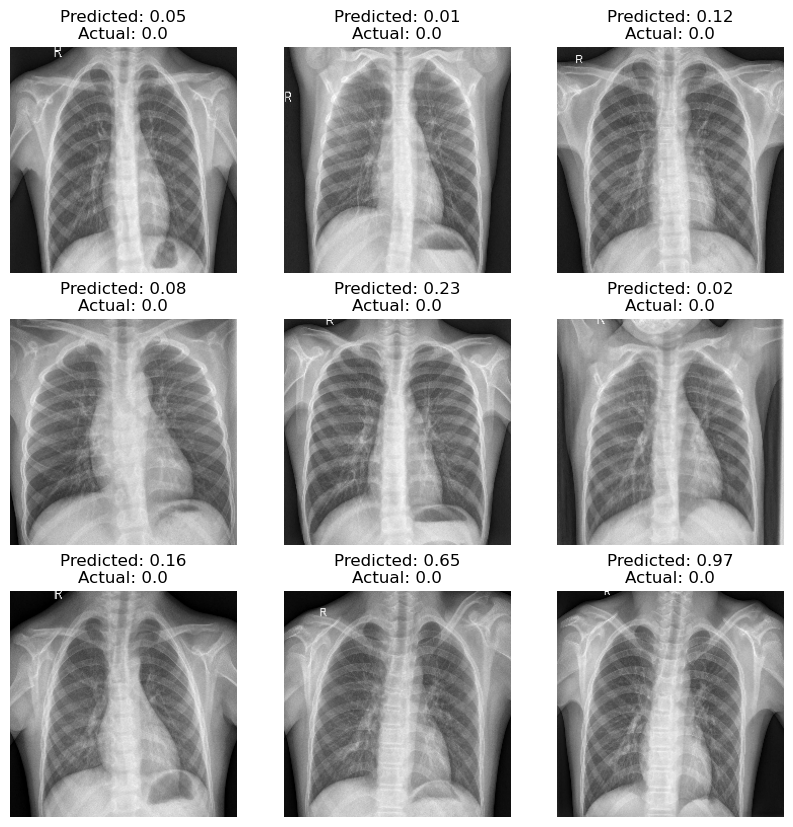

In [9]:
import matplotlib.pyplot as plt

# Set the number of images to display
num_images = 9

# Set up the figure
plt.figure(figsize=(10, 10))

# Get a batch of images and labels from the test set
images, labels = test_ds.as_numpy_iterator().next()

# Make predictions on the batch of images
predictions = model.predict_on_batch(images)

# Loop through the images and display them with their predicted labels
for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype('uint8'))
    plt.title(f'Predicted: {predictions[i][0]:.2f}\nActual: {labels[i][0]}')
    plt.axis('off')

#### As we can see that how close our predictions are